In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
file_paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        file_paths.append(full_path)
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

print(*file_paths[0:7], sep='\n')

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet


### Citations
- ref(1) : "https://www.kaggle.com/code/swandipsingha/cmi-36-ranked-notebook"


### Imports

In [8]:
# pre-processing
from tqdm import tqdm 
from concurrent.futures import ThreadPoolExecutor

# viz
import seaborn as sns
import matplotlib.pyplot as plt



# High - level plan

A/ 
- Data loading (threading)
- EDA
- Data preprocessing
- baseline model -> what's the best model for the job?
- cross validation
- train and evaluate the model
- submit first prediction

B/ 
- create a better model
- feature engineering
- hyper-parameters
- find an existing model and perform transfer learning



# A/

### A.i) Loading the data

__learnings__
- `.describe()` returns 8 statistical values for each column of your df. if you reshape the .describe() dataframe into a series you may have +/- 8 features than you expect if you don't drop/add columns from your original df
- you can replace TS data with its statistical values ??
- `ThreadPoolExecutor.map(lambda x: func(x, "const"), iter(x_n))` -> starts a thread for each element in iter(). Useful for I/O
- don't forget to use `os.path.join(dirname, filename, "suffix")` to load data
- `os.listdir(dirname)` outputs a list of the name of each sub-directory of given directory path
- `.reshape()` is used for numpy arrays

In [46]:
# read in tabular data (.csv)
sample_submission = pd.read_csv(file_paths[0])
data_dict_df = pd.read_csv(file_paths[1]) # information about patient data
train_csv_df = pd.read_csv(file_paths[2])
test_csv_df = pd.read_csv(file_paths[3])

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,...,63.1265,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,...,47.2211,NaN,NaN,Winter,3.670,Winter,27.0,40.0,Fall,3.0
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,...,50.4767,NaN,NaN,Fall,1.270,NaN,NaN,NaN,Fall,2.0
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.0
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# len(os.listdir("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet"))
pd.read_parquet(file_paths[5]).describe().values.reshape(-1).shape

(104,)

In [36]:
stats = pd.read_parquet(file_paths[4])
# stats.drop('step', axis=1, inplace=True)
# stats.describe()
# stats, indexes = stats.describe().values.reshape(-1), filename.split('=')
# stats, indexes
# df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats))])
# df['id'] = indexes


,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
count,43330.000000,43330.000000,43330.000000,43330.000000,43330.000000,43330.000000,43330.0,43330.000000,43330.000000,4.333000e+04,43330.000000,43330.0,43330.000000
mean,21664.500000,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.0,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683
std,12508.437919,0.453665,0.502702,0.585710,0.106351,42.947170,0.0,208.168976,112.404045,1.942842e+13,1.931421,0.0,14.244914
min,0.000000,-1.746094,-2.905339,-1.048372,0.000000,-89.833092,0.0,0.000000,3824.000000,5.500000e+10,1.000000,3.0,41.000000
25%,10832.250000,-0.684180,-0.309863,-0.649974,0.006432,-41.541863,0.0,2.392969,4028.666748,3.689000e+13,3.000000,3.0,42.000000
50%,21664.500000,-0.366849,0.024974,-0.245378,0.023637,-15.086617,0.0,6.926828,4070.000000,5.347750e+13,5.000000,3.0,50.000000
75%,32496.750000,-0.010677,0.400677,0.204727,0.041420,12.220764,0.0,15.000000,4147.000000,6.640875e+13,6.000000,3.0,53.000000
max,43329.000000,1.507865,1.666354,1.546979,4.004276,89.751656,0.0,2633.250000,4188.500000,8.611000e+13,7.000000,3.0,85.000000


In [25]:
# read in the TS data (.parquet) --> code from ref(1)

def process_file(filename, dirname):
    # load .parquet file and return the statistical data
    
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]


def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)

    # 
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [26]:
# load TS data -> (x,y), x = number of patients, y = number of statistical values for the TS dataset
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 12.91it/s]


In [45]:
train_csv_df.shape, train_ts.shape, test_csv_df.shape, test_ts.shape

((3960, 82), (996, 97), (20, 59), (2, 97))

### A.ii) EDA

### EDA of tabular data

In [47]:
# what features are missing in `test_csv_df`?
train_cols = train_csv_df.columns
test_cols = test_csv_df.columns

for col in train_cols:
    if not col in test_cols:
        print(col)

PCIAT-Season
PCIAT-PCIAT_01
PCIAT-PCIAT_02
PCIAT-PCIAT_03
PCIAT-PCIAT_04
PCIAT-PCIAT_05
PCIAT-PCIAT_06
PCIAT-PCIAT_07
PCIAT-PCIAT_08
PCIAT-PCIAT_09
PCIAT-PCIAT_10
PCIAT-PCIAT_11
PCIAT-PCIAT_12
PCIAT-PCIAT_13
PCIAT-PCIAT_14
PCIAT-PCIAT_15
PCIAT-PCIAT_16
PCIAT-PCIAT_17
PCIAT-PCIAT_18
PCIAT-PCIAT_19
PCIAT-PCIAT_20
PCIAT-PCIAT_Total
sii


we are missing the following data in the test set:
- all the PCIAT scores
- the ssi labels

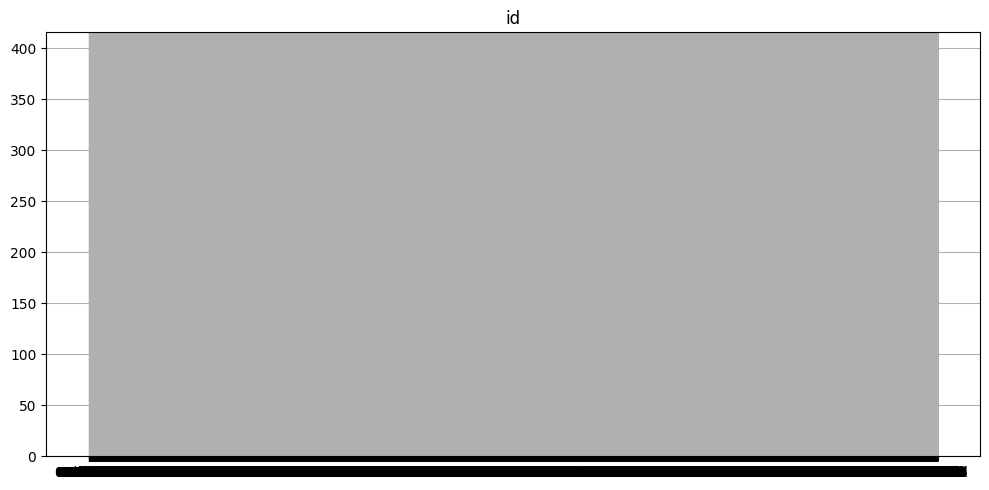

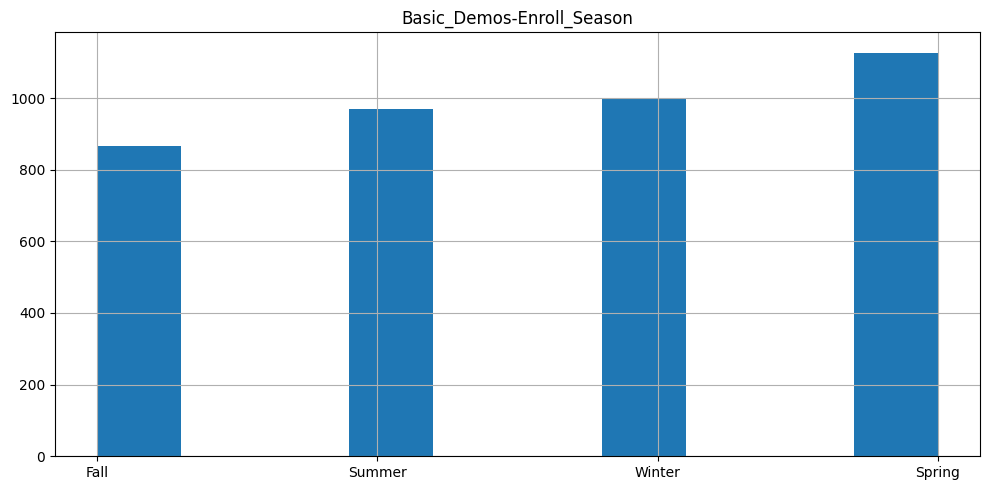

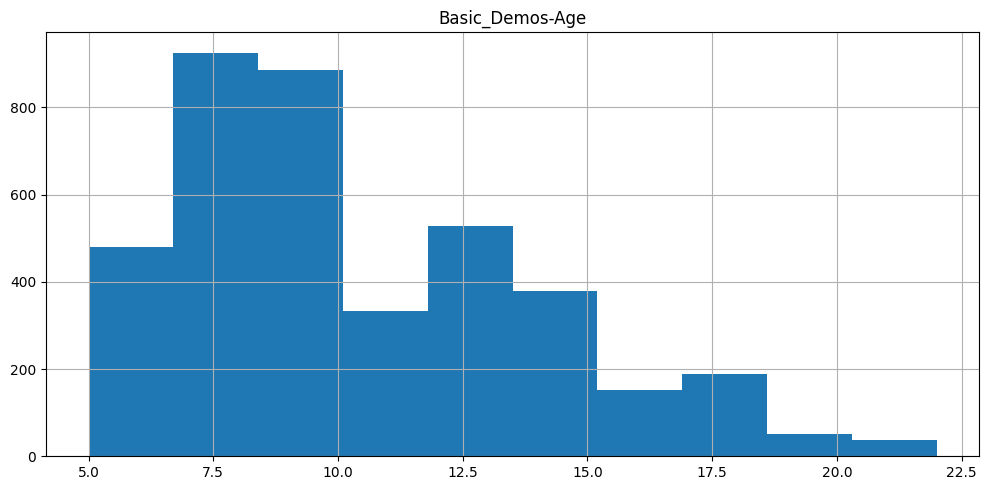

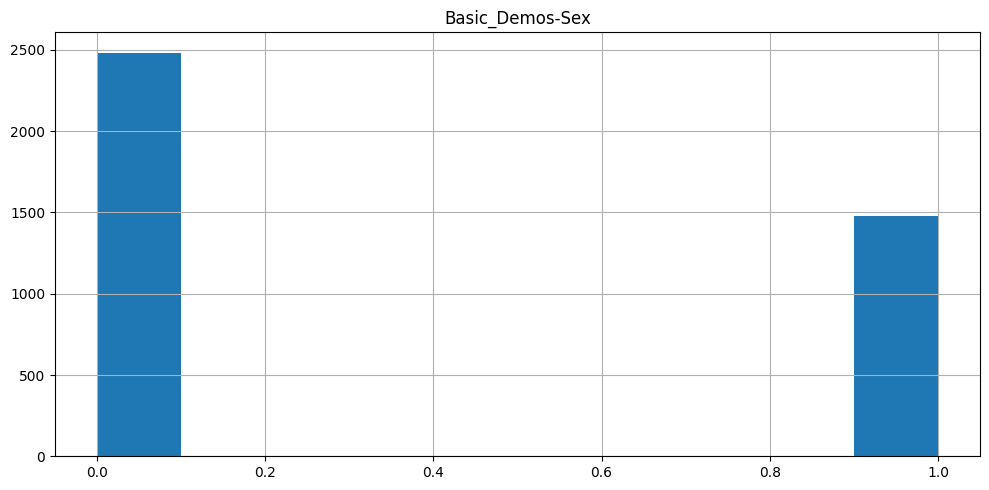

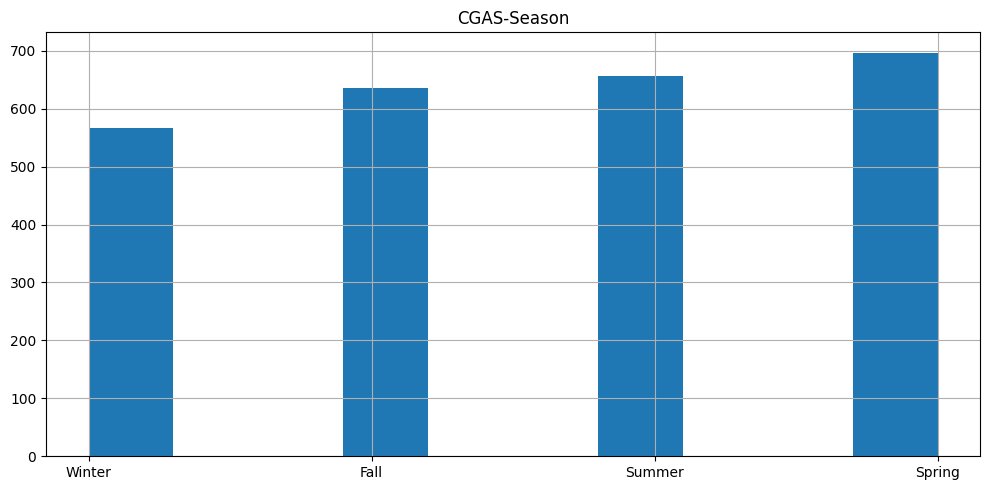

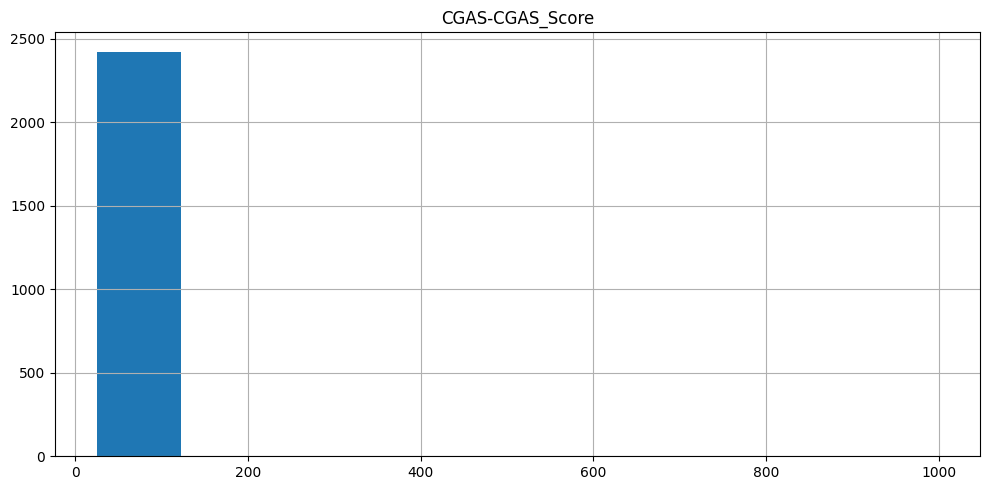

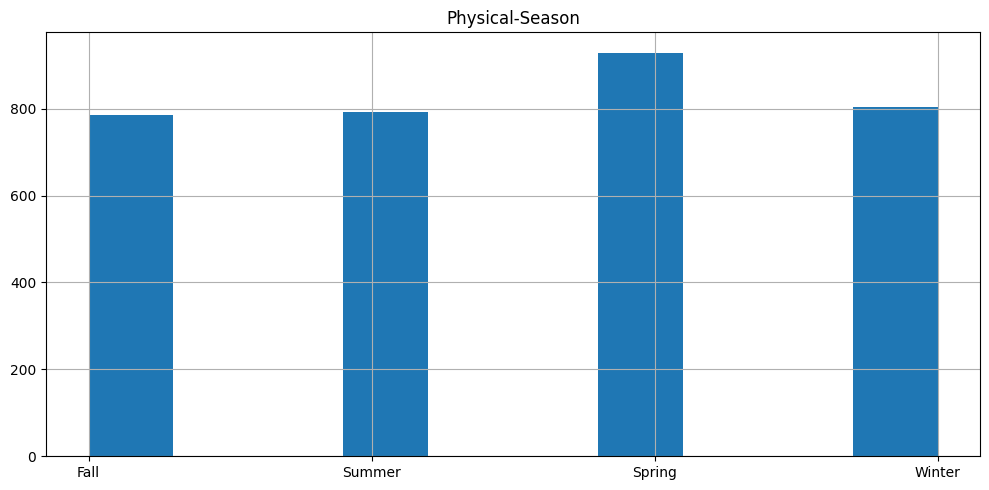

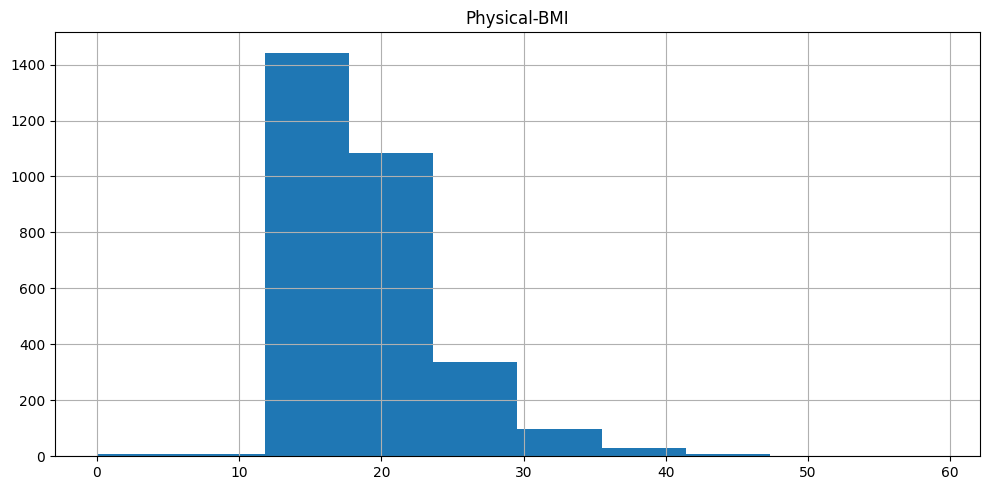

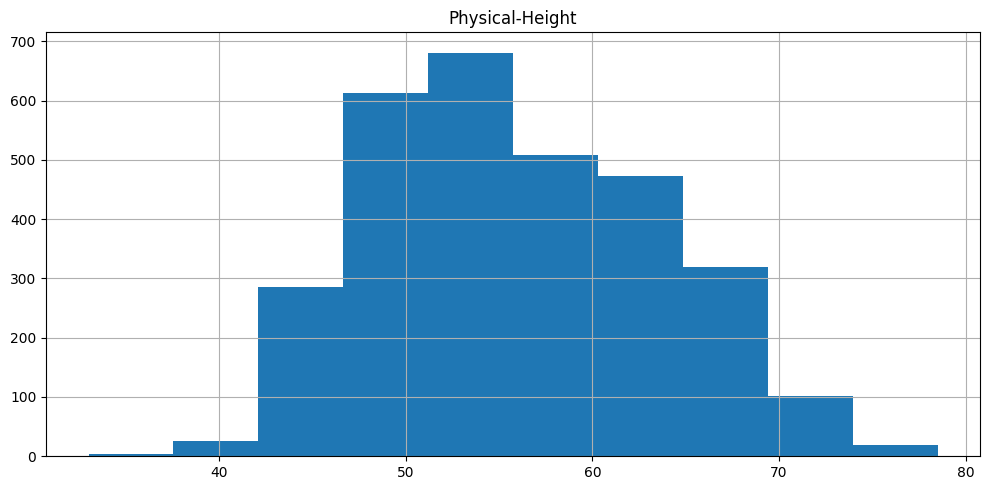

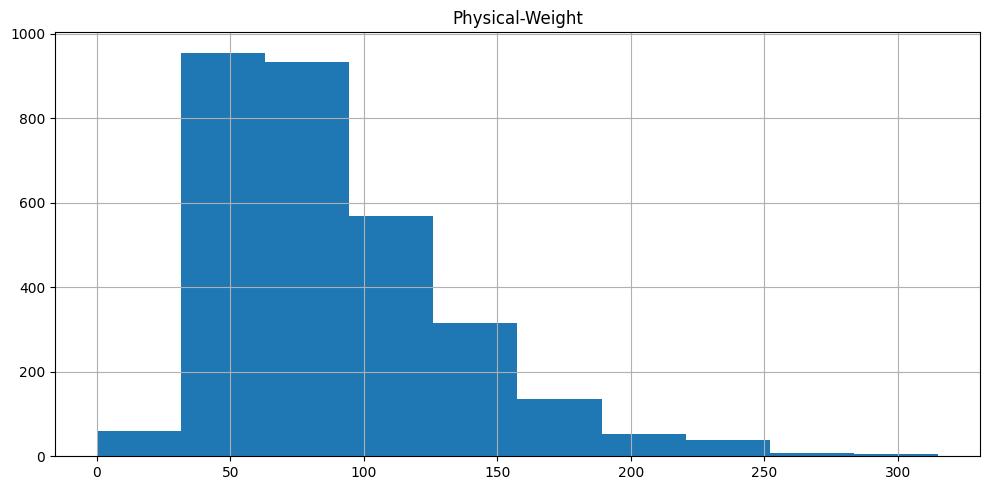

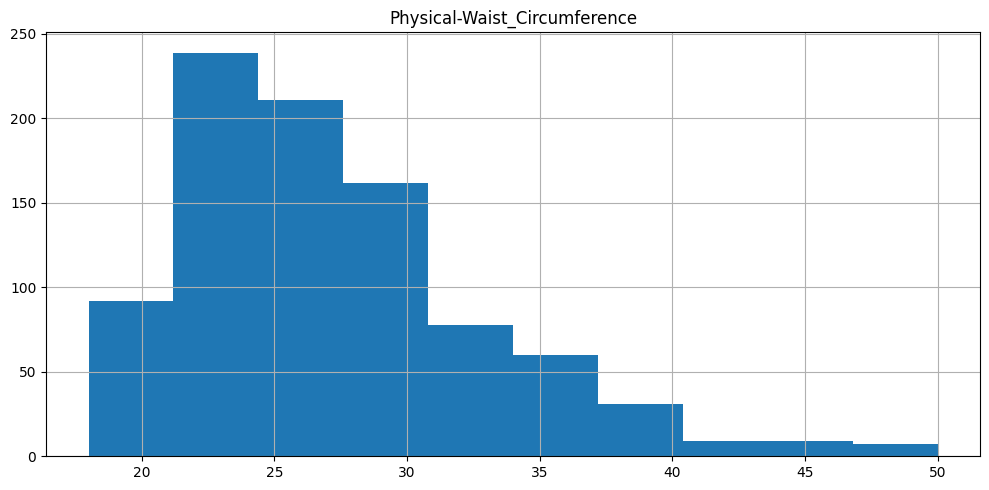

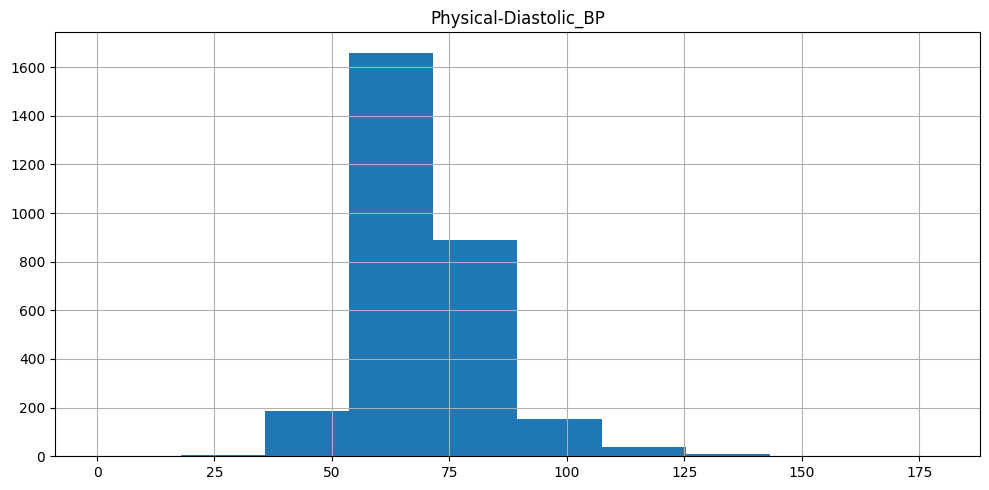

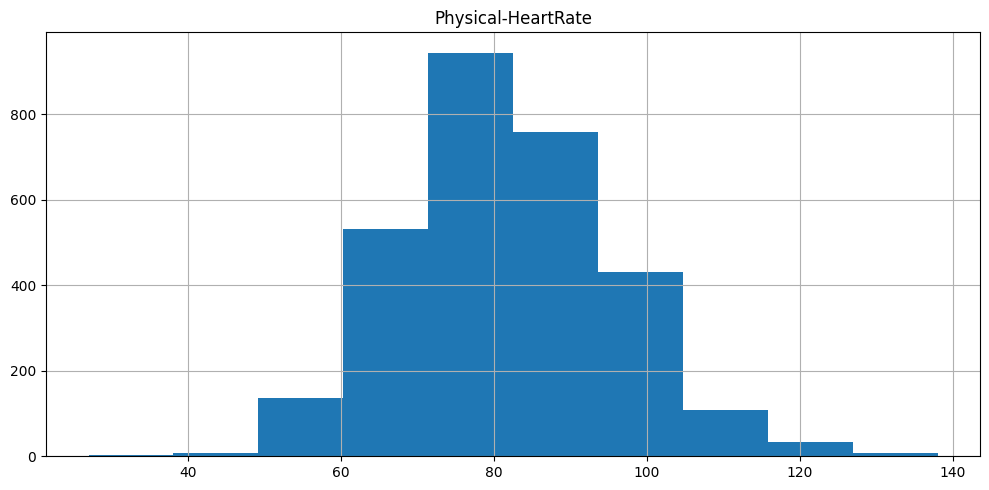

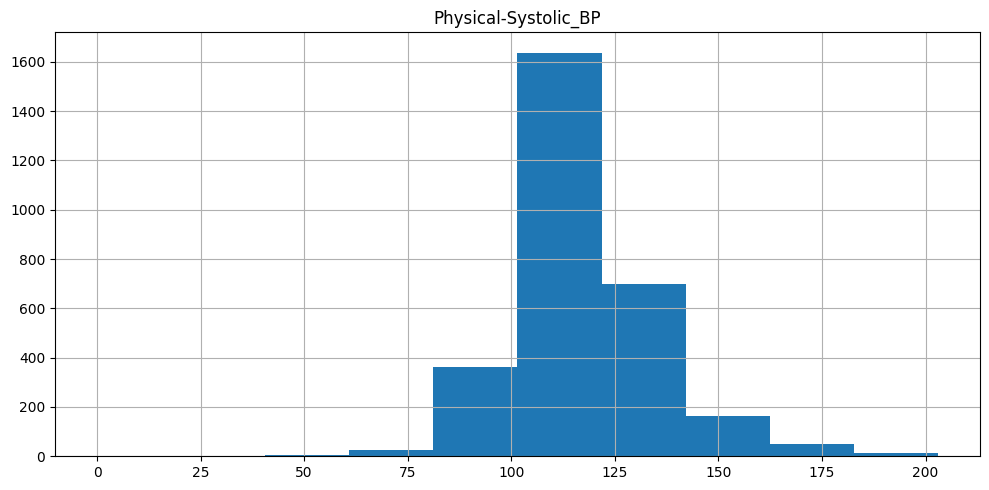

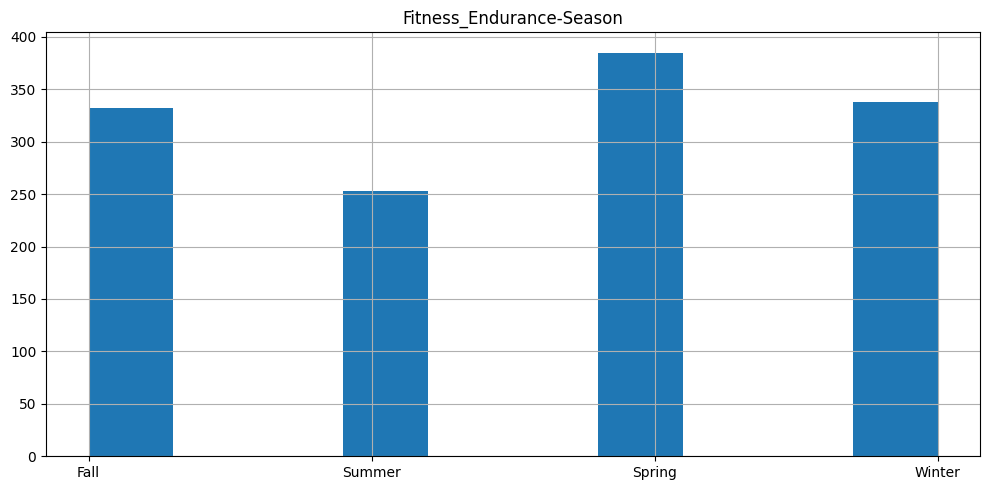

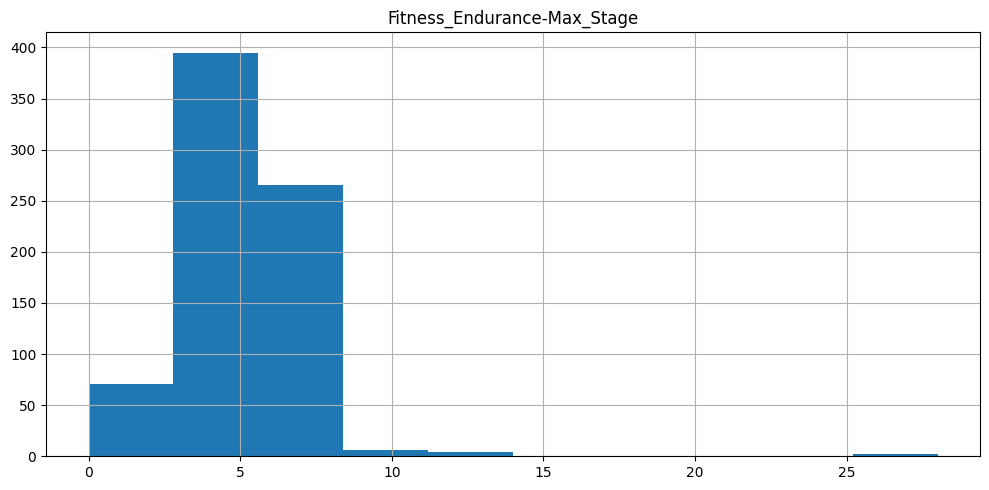

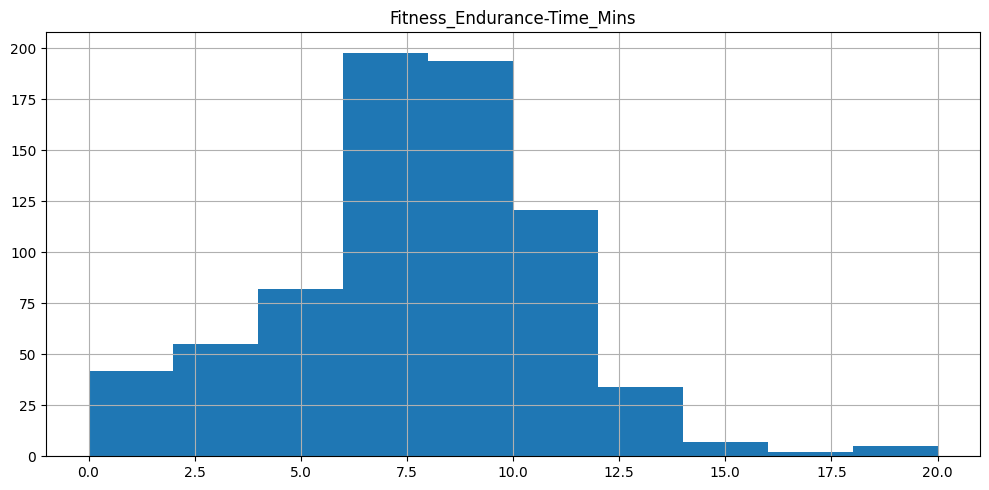

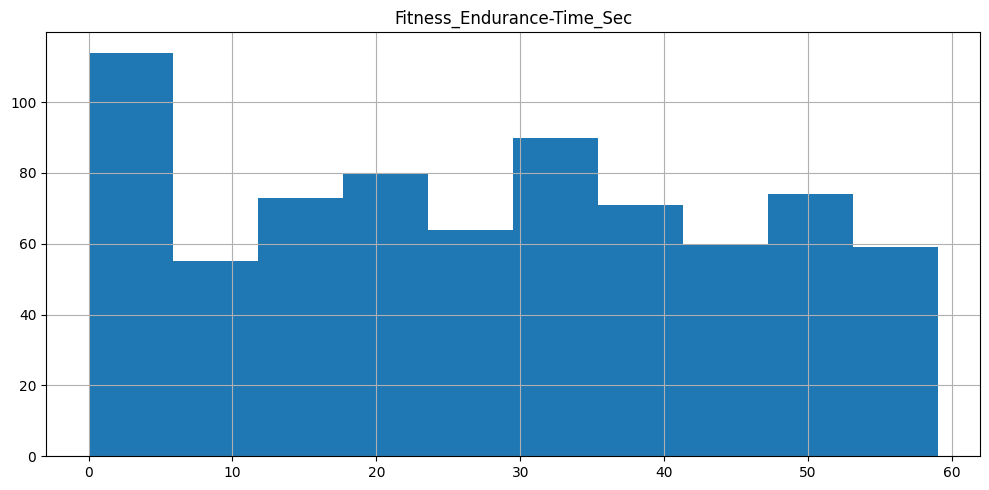

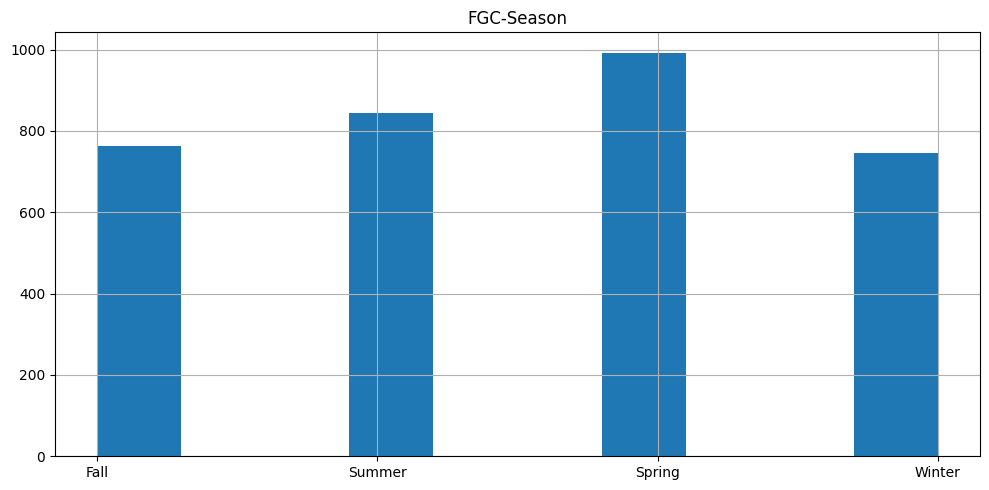

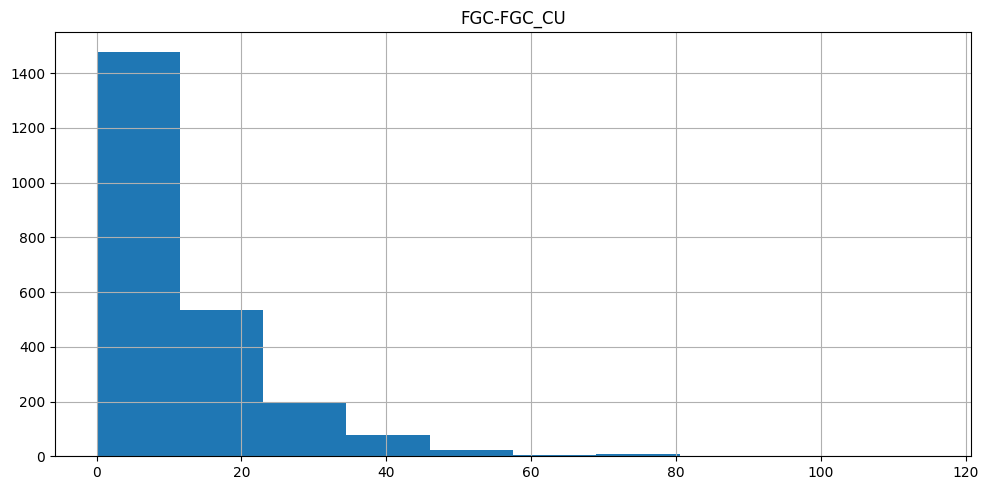

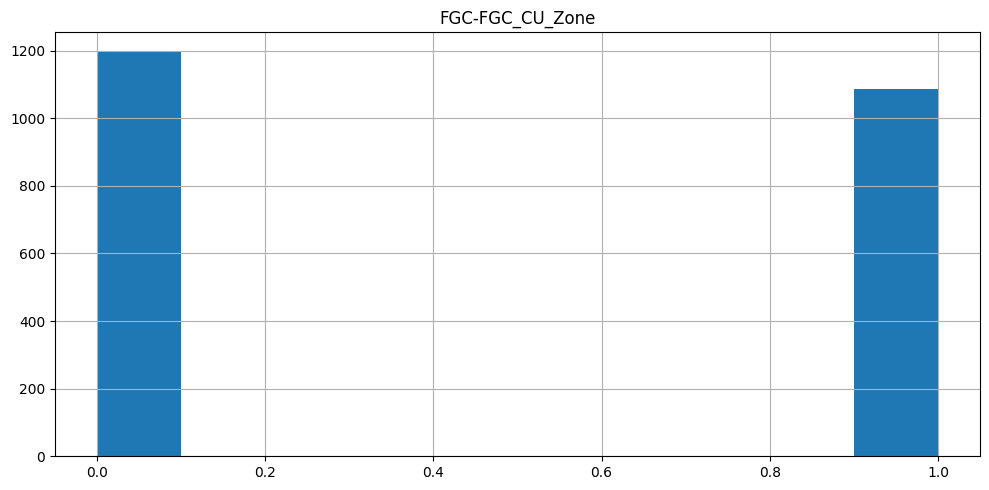

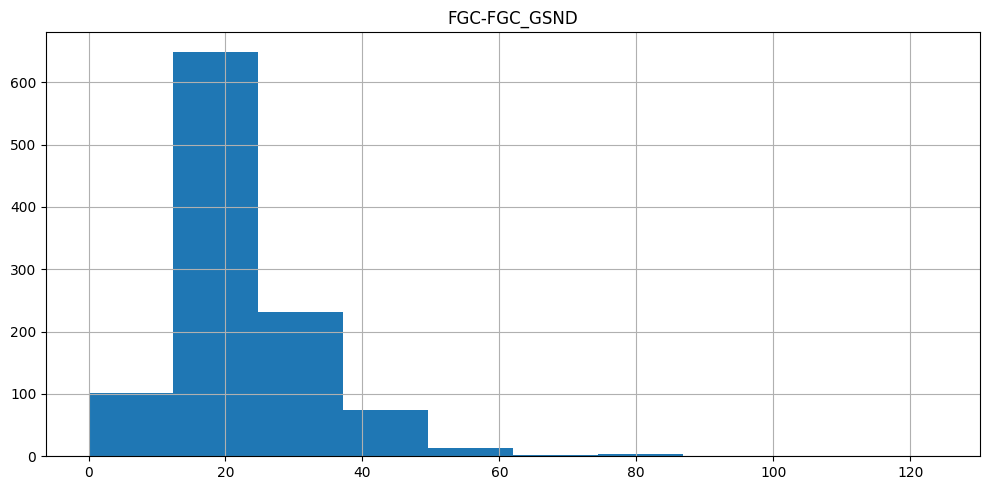

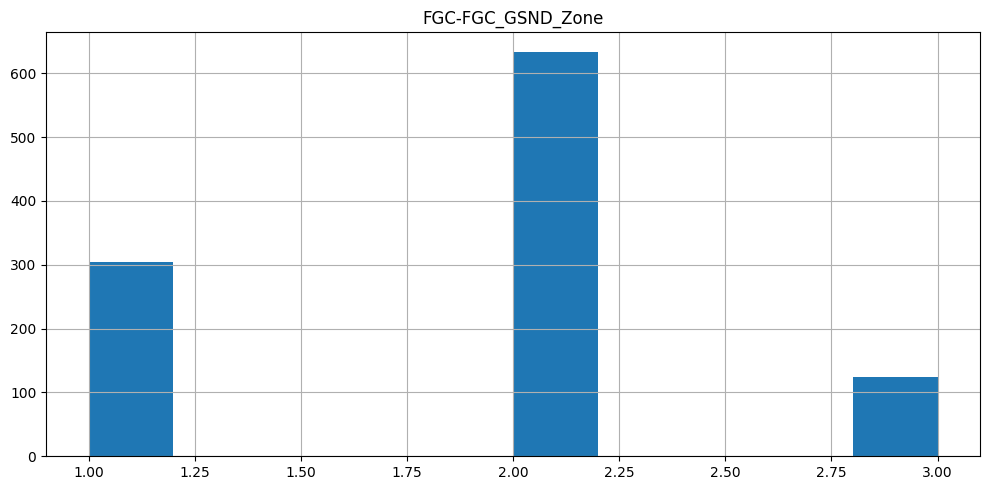

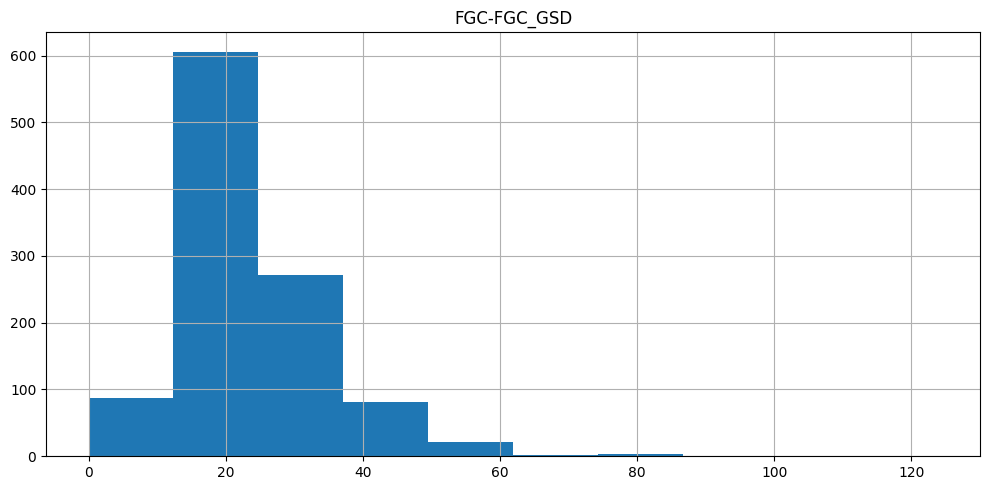

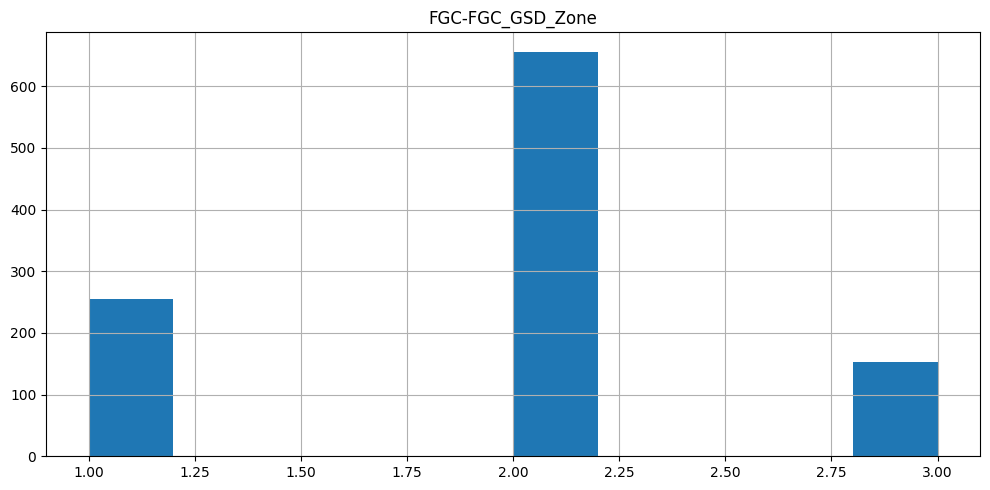

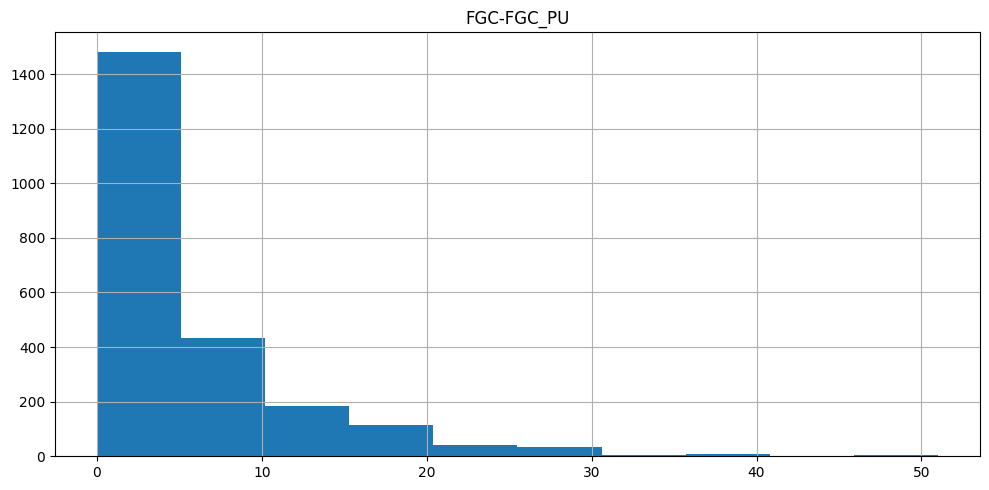

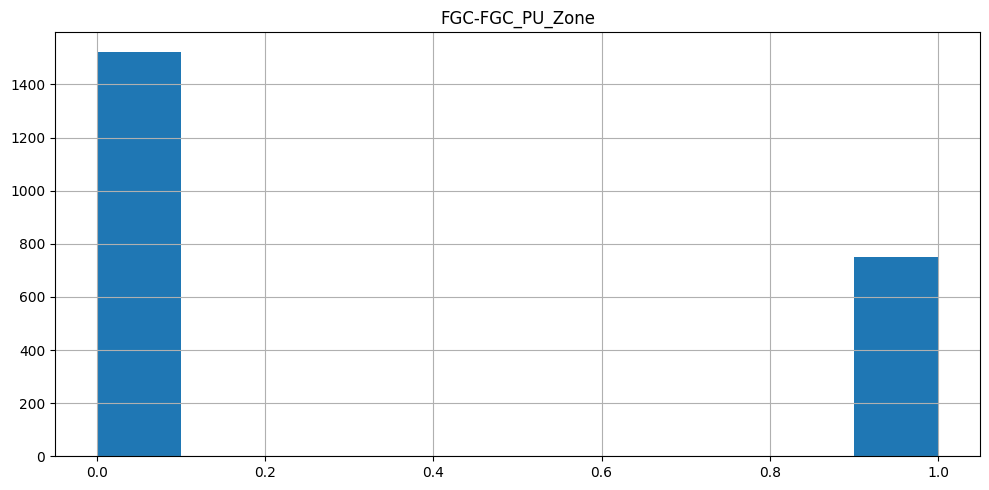

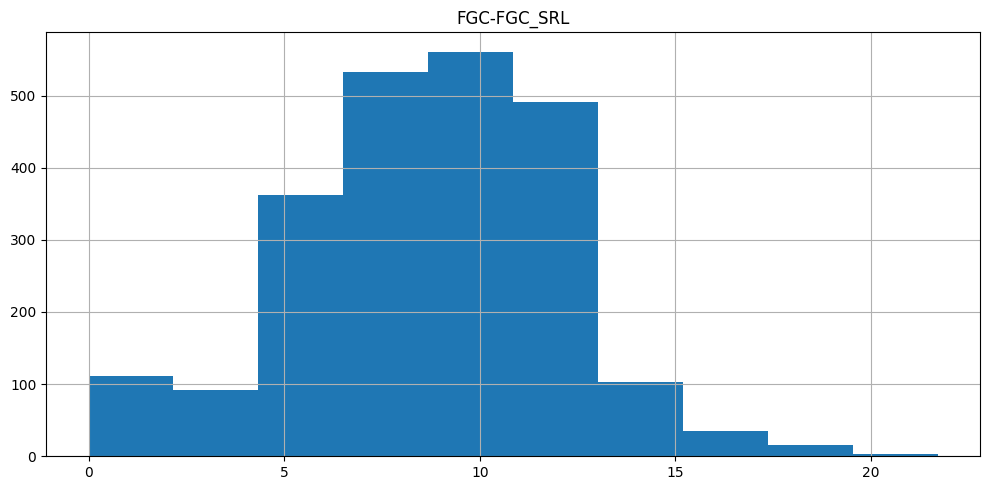

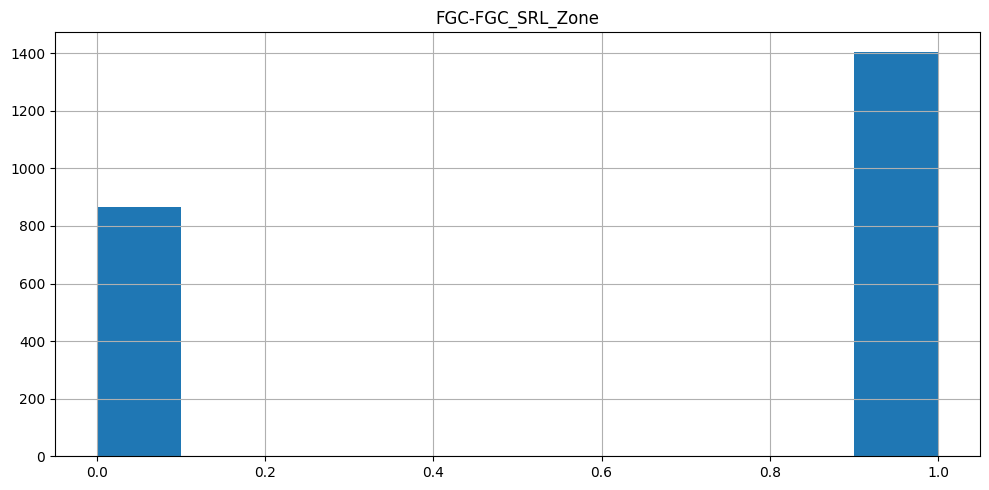

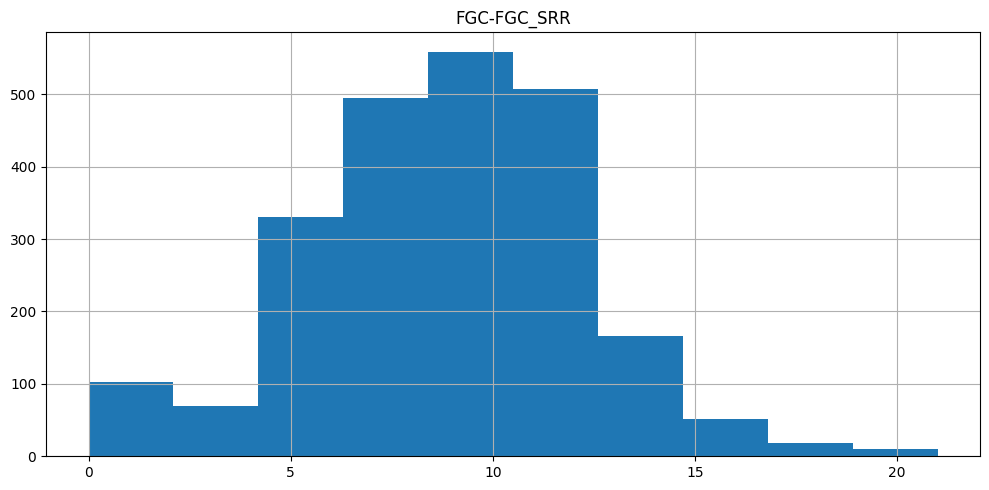

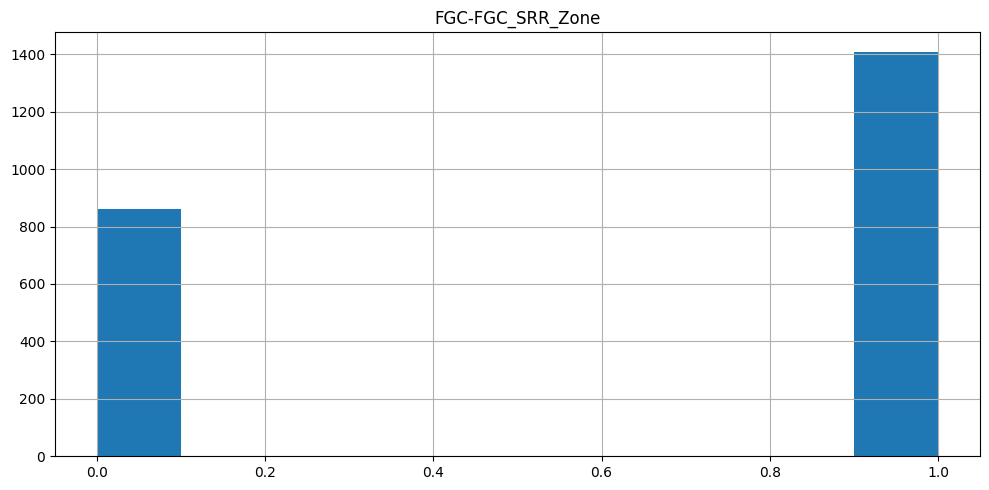

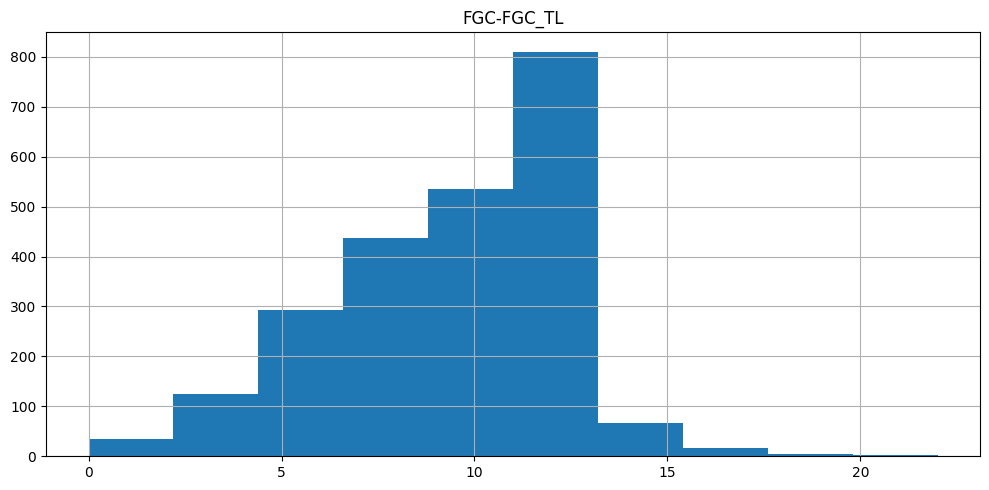

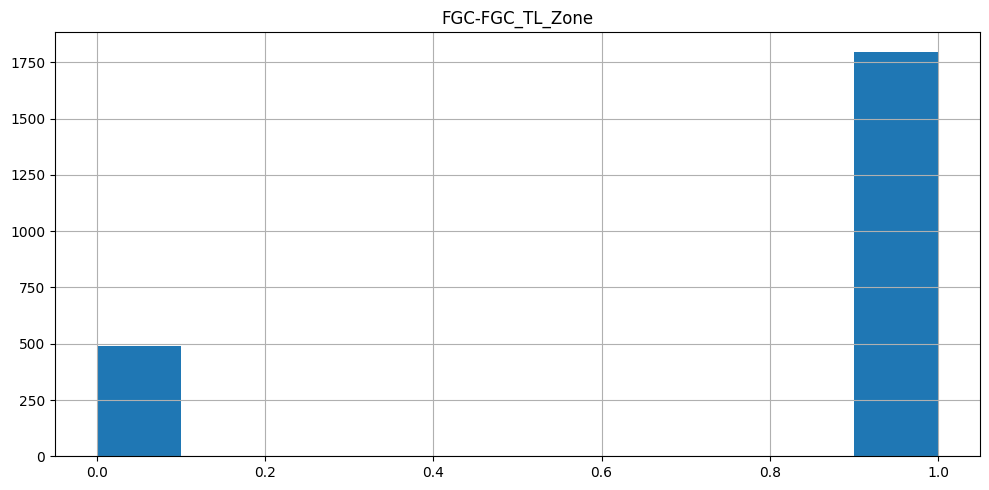

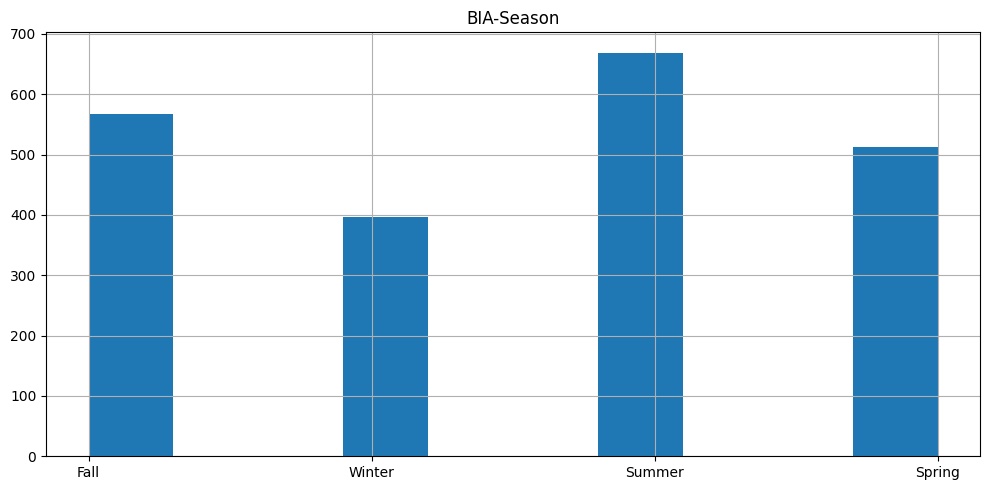

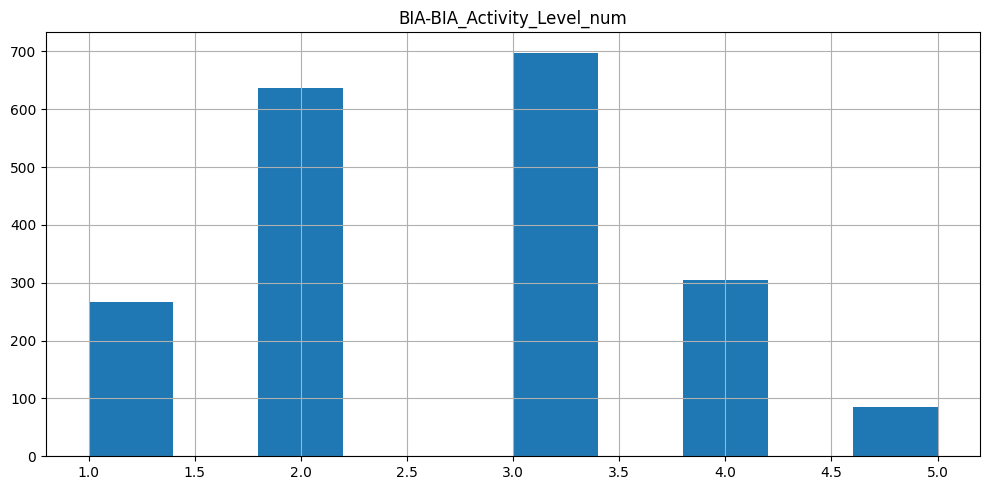

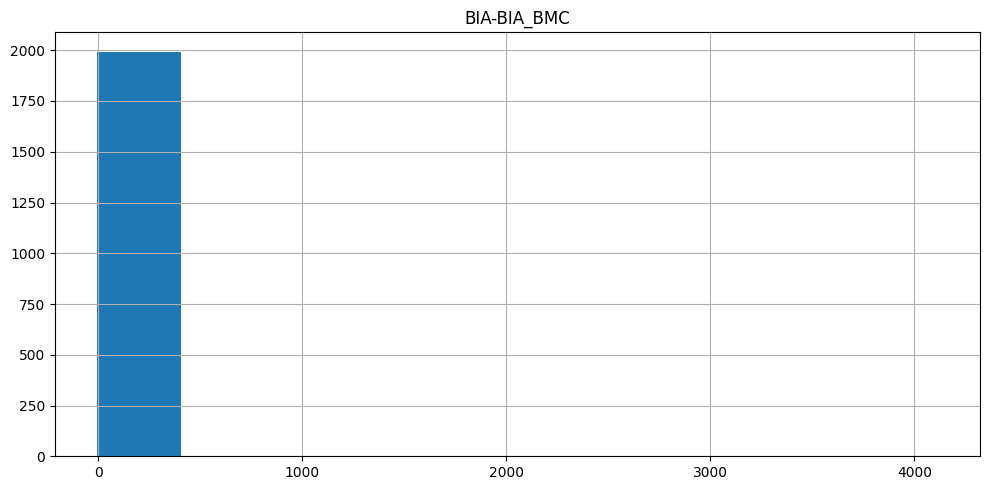

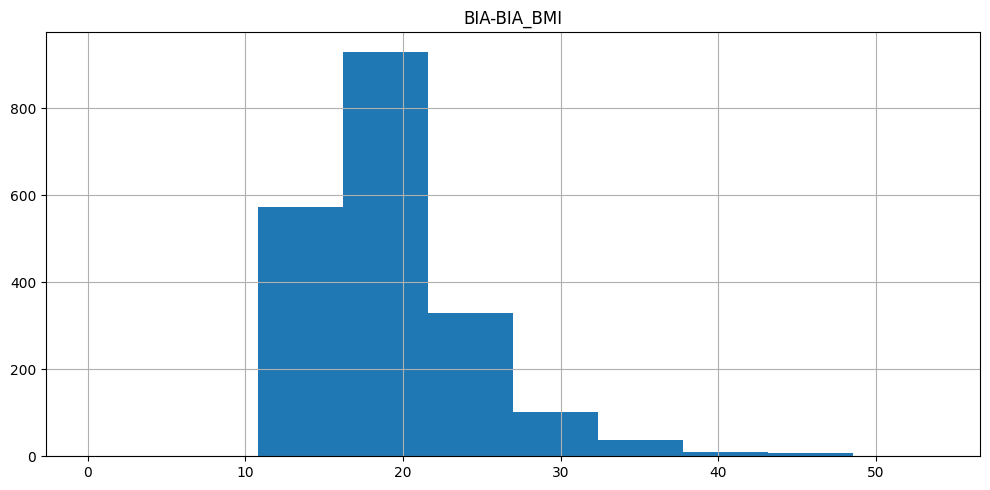

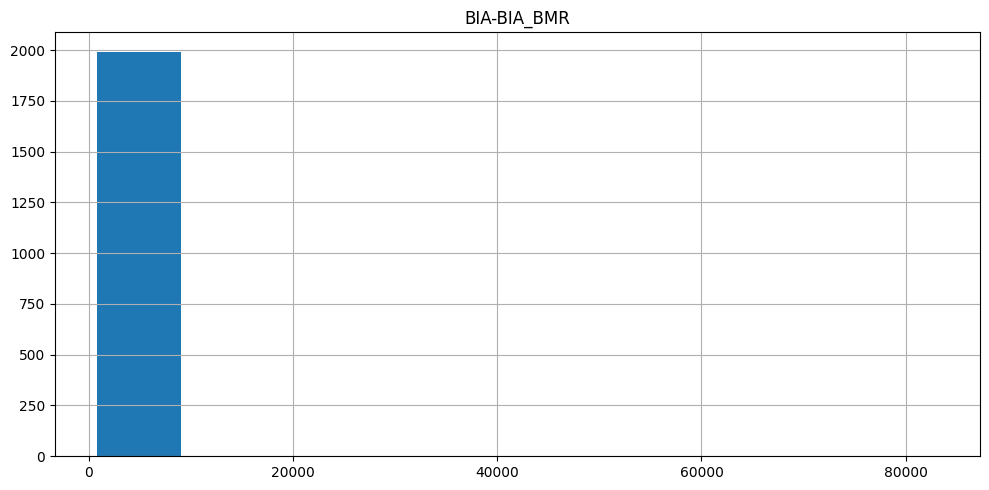

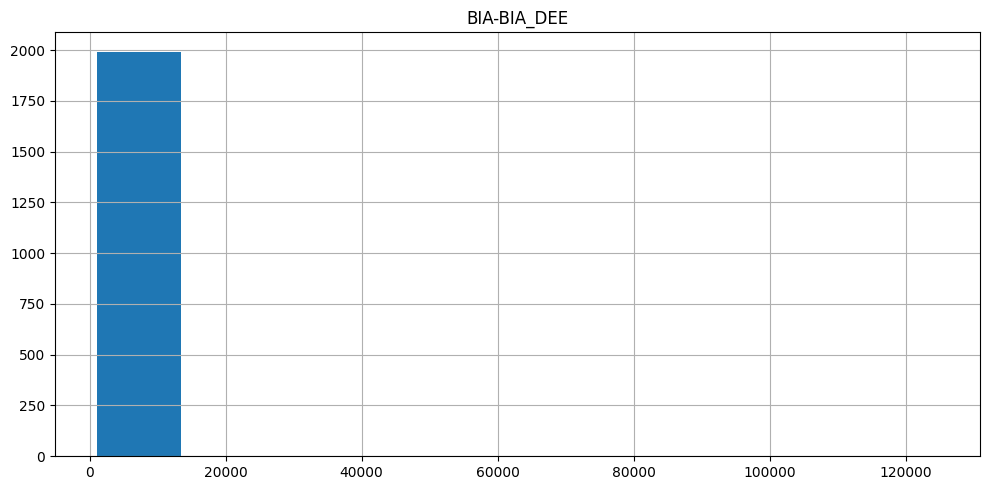

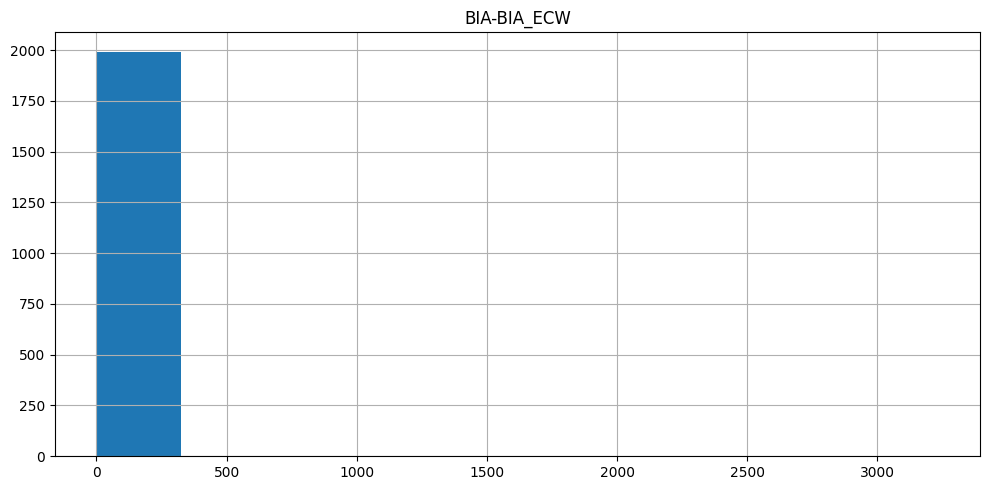

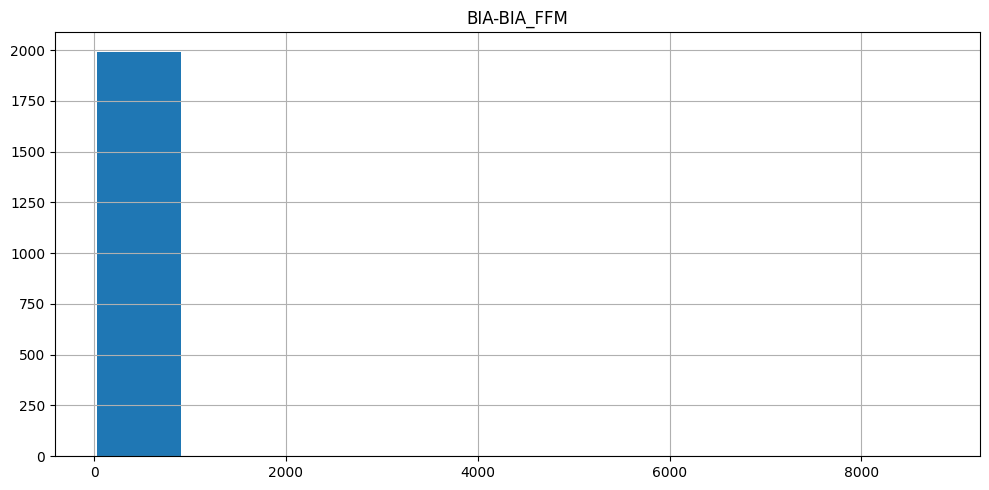

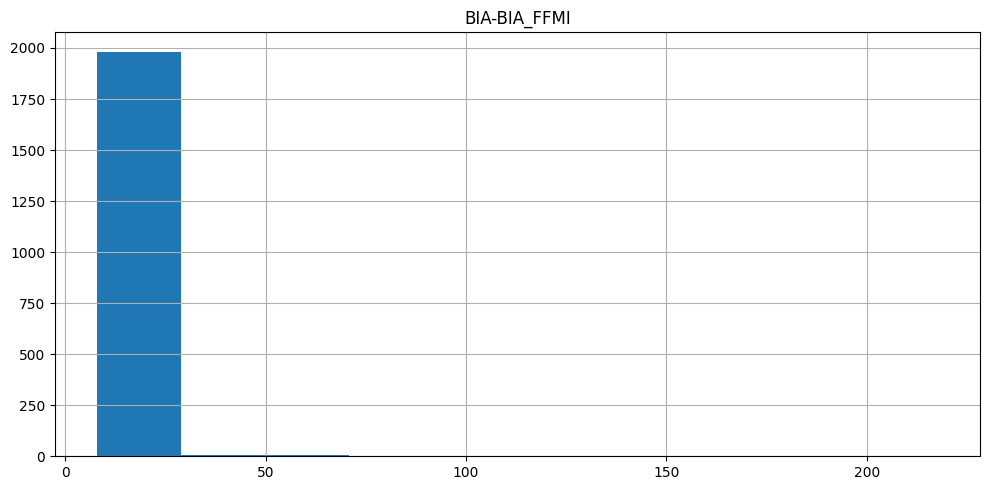

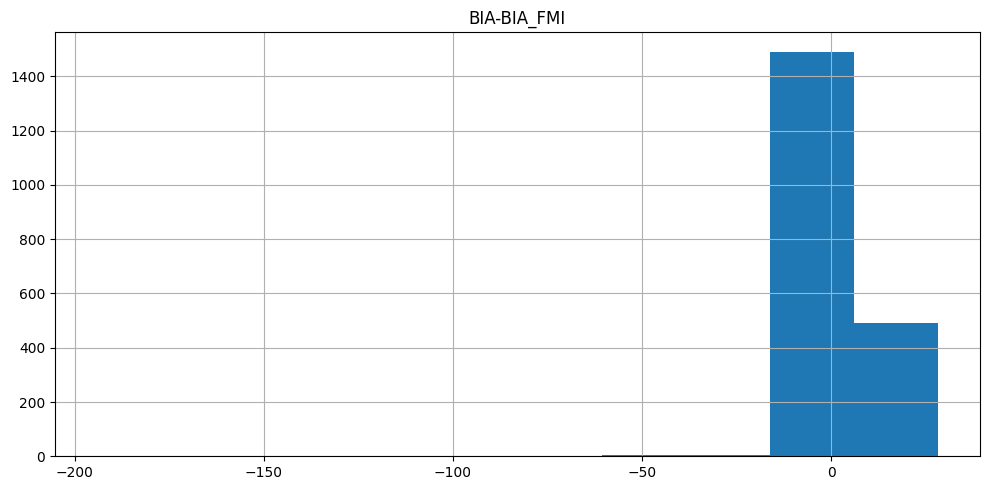

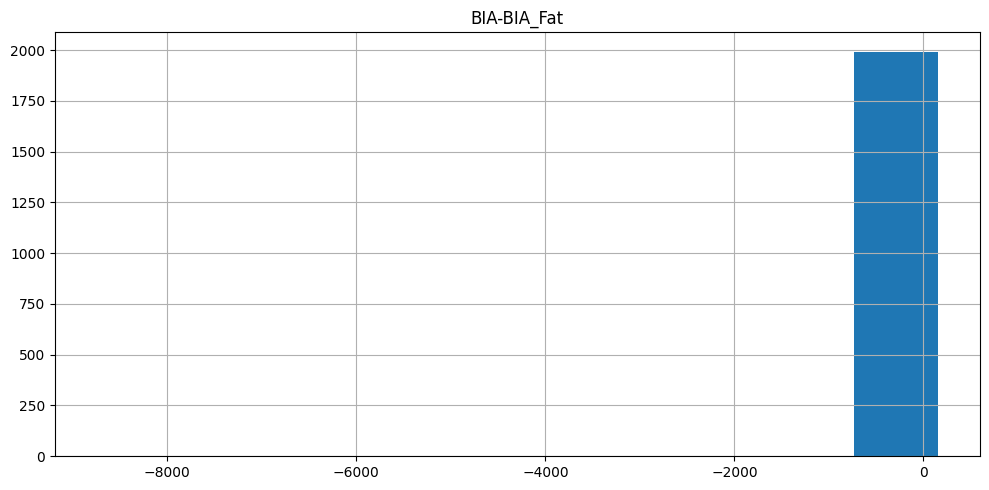

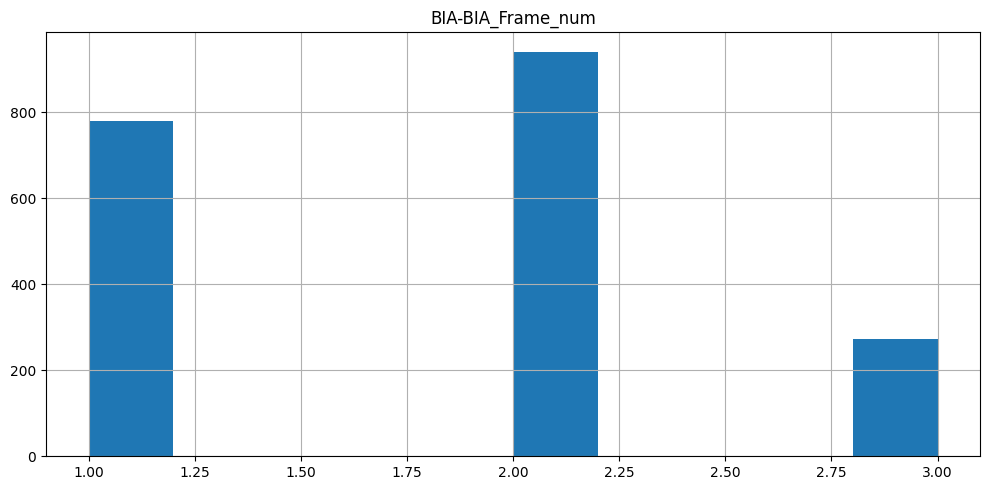

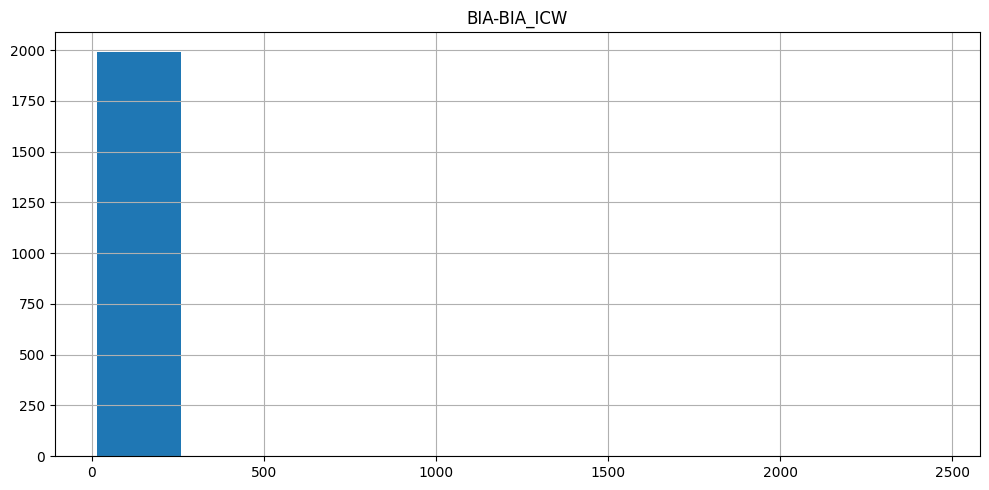

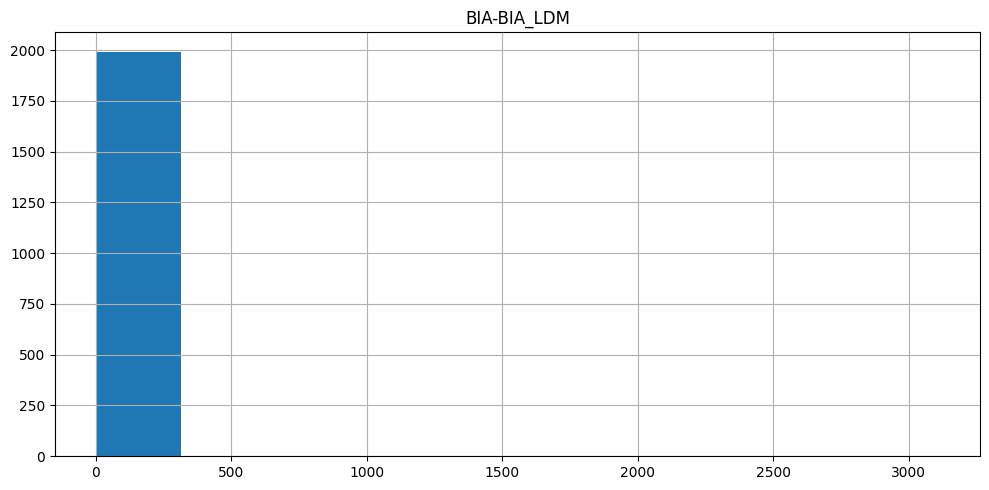

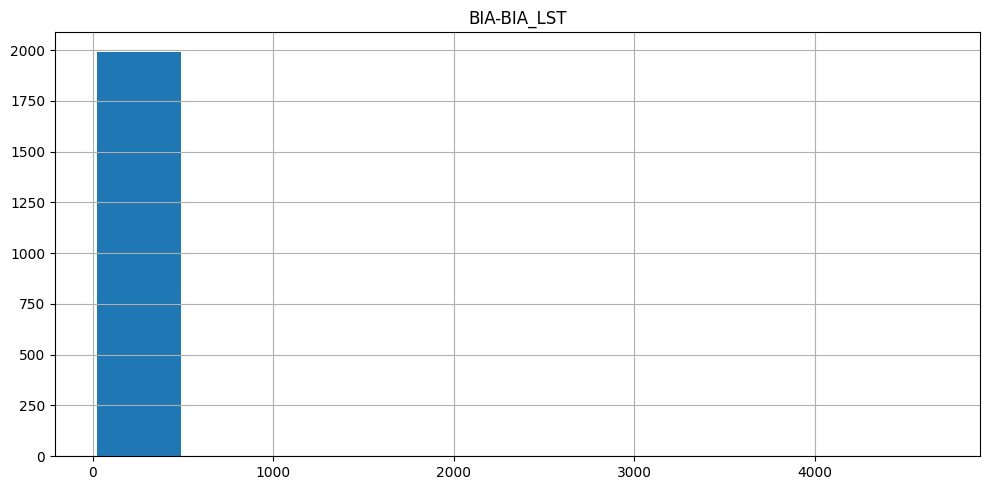

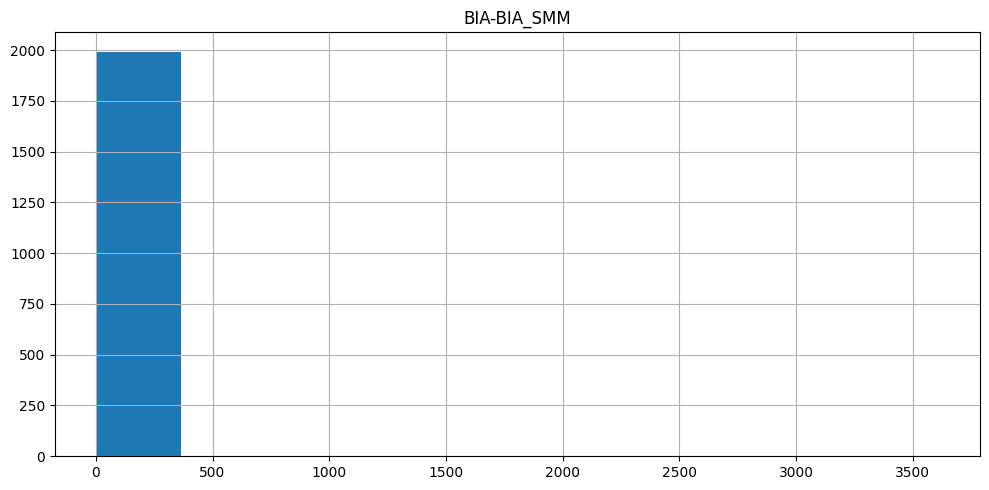

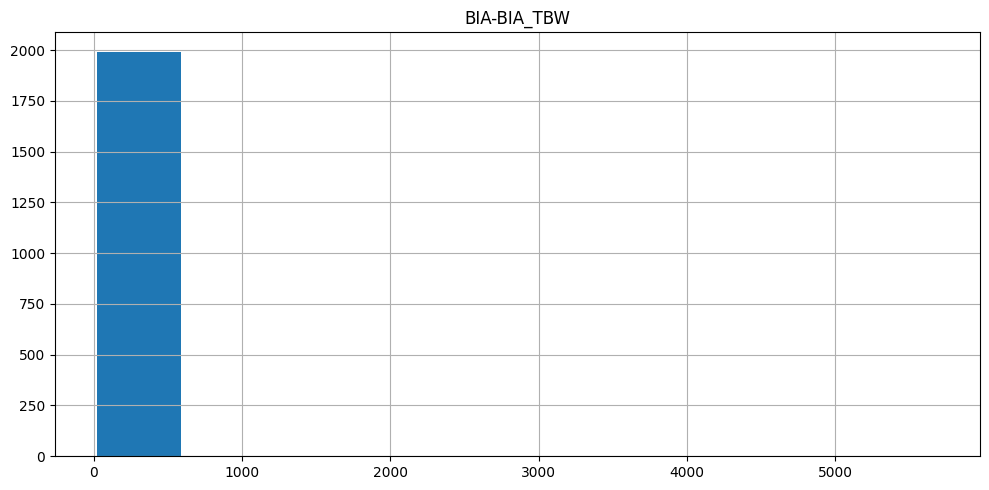

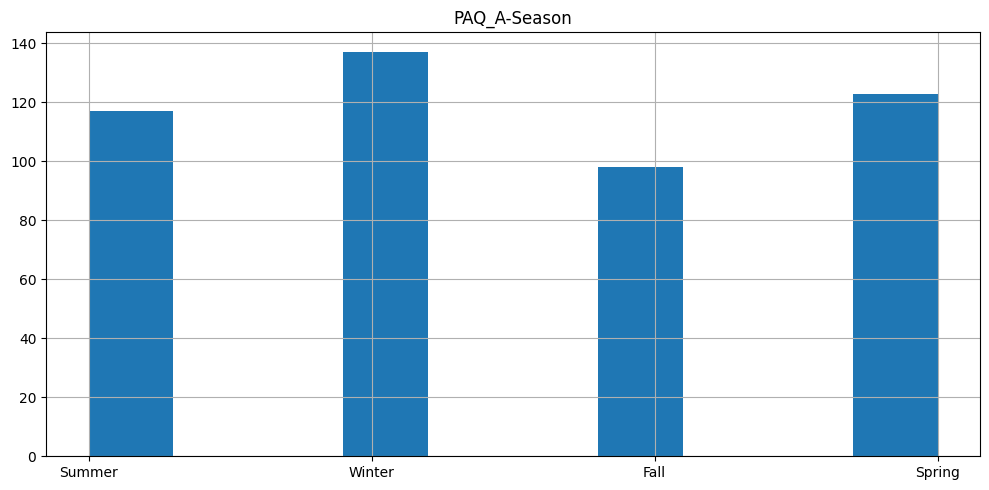

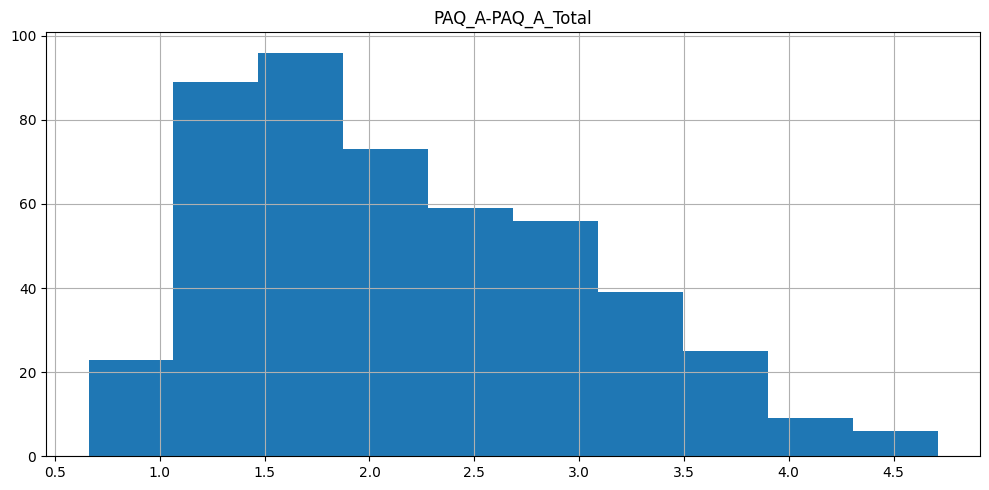

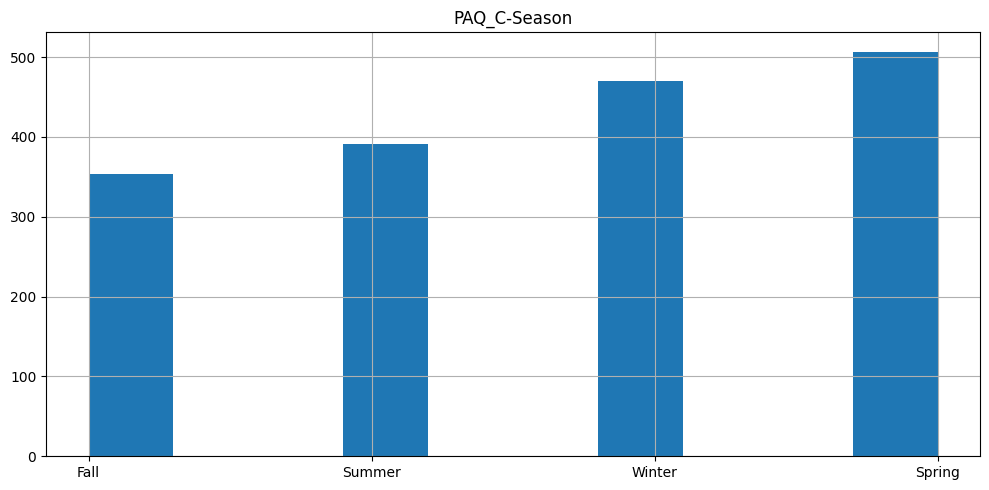

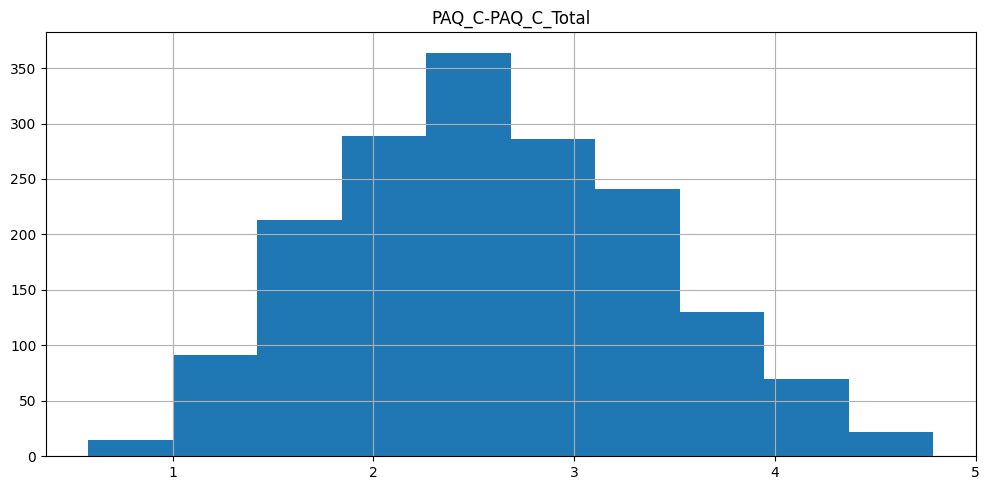

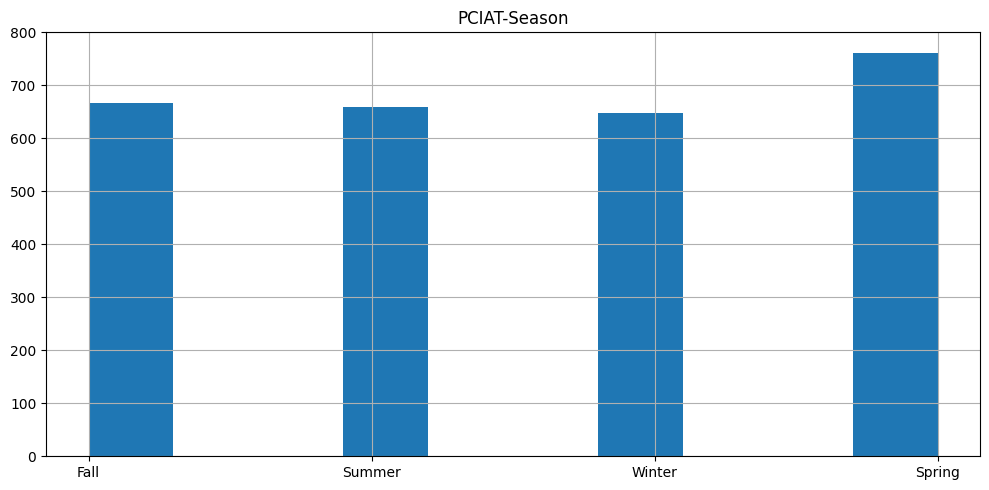

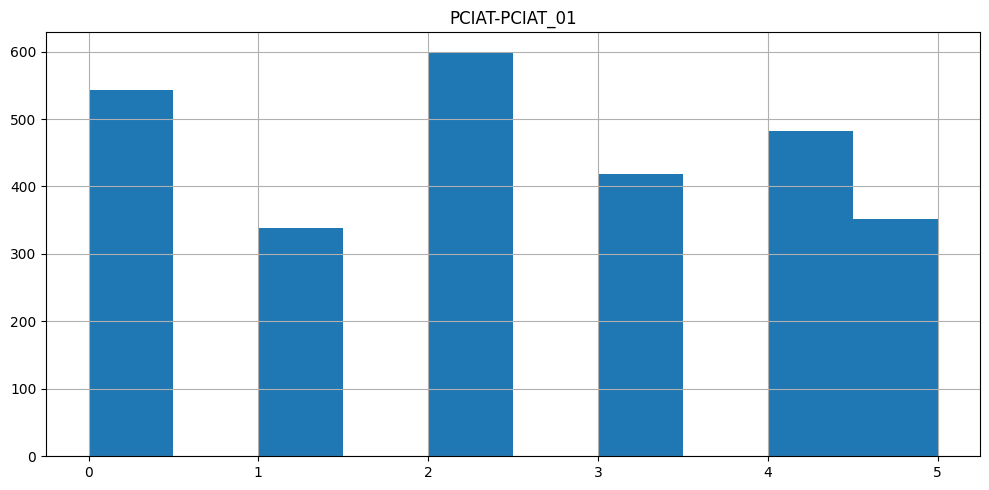

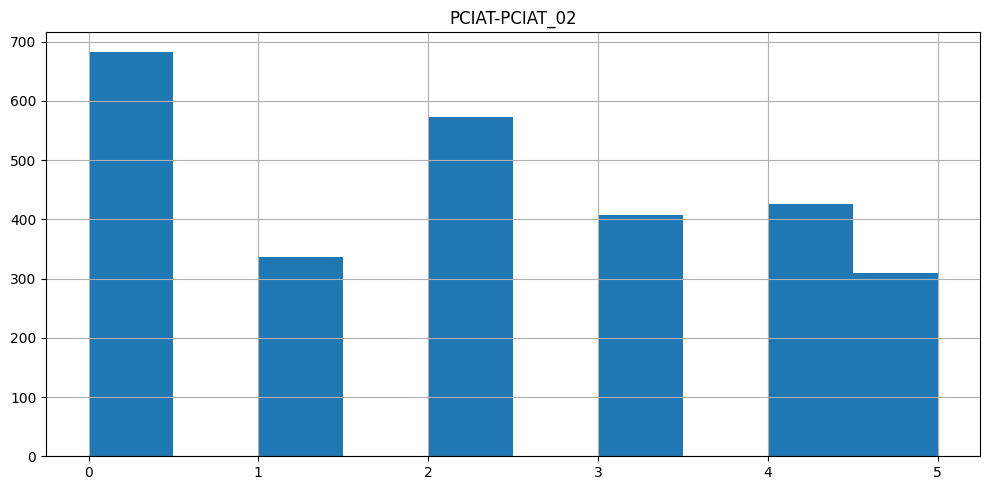

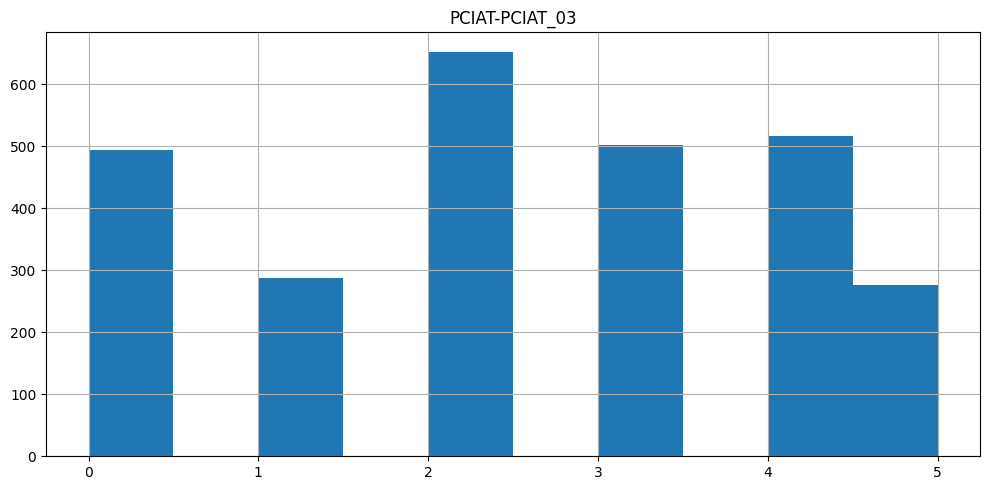

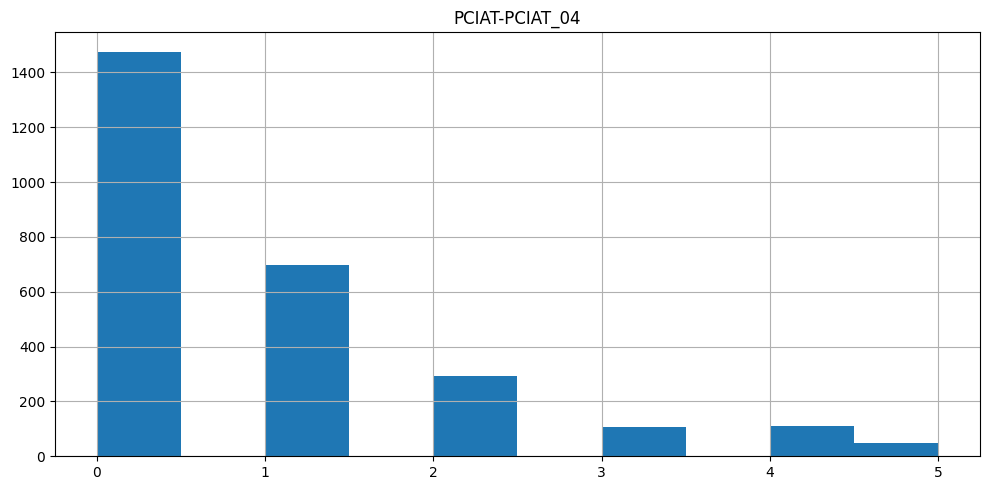

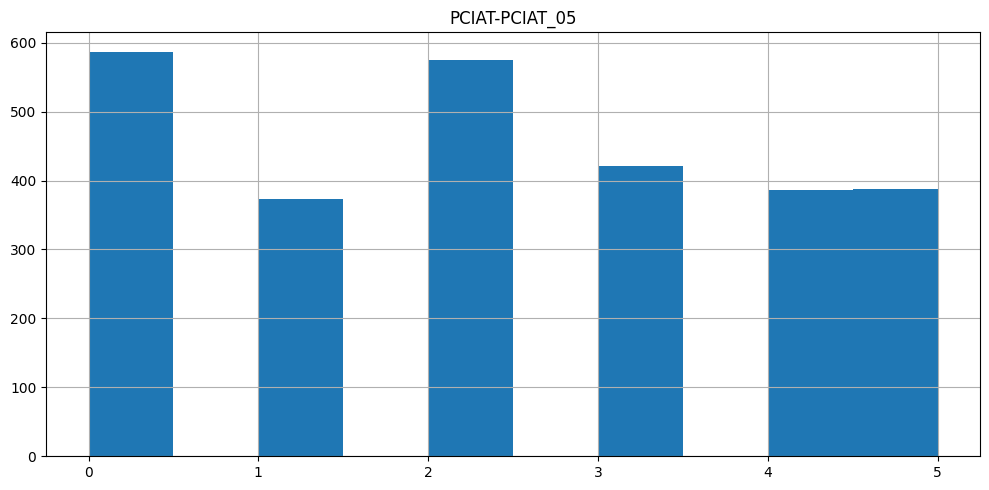

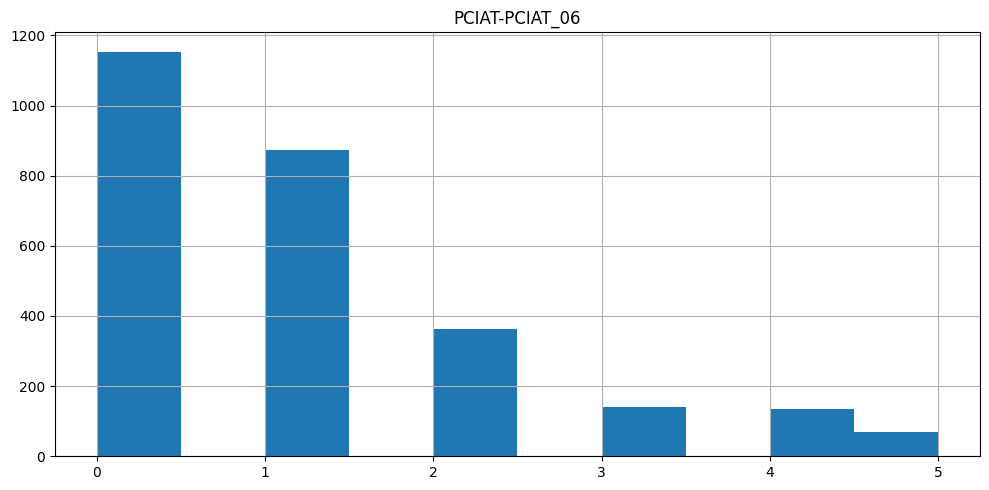

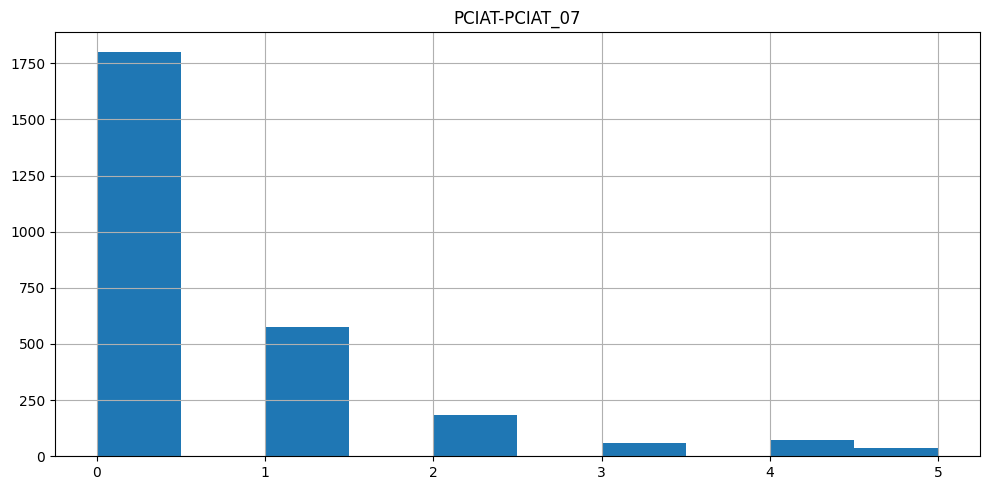

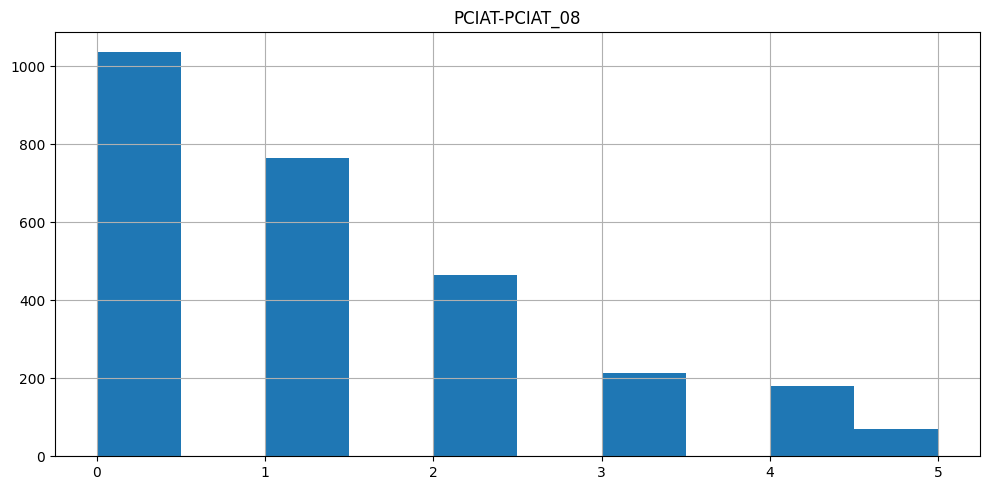

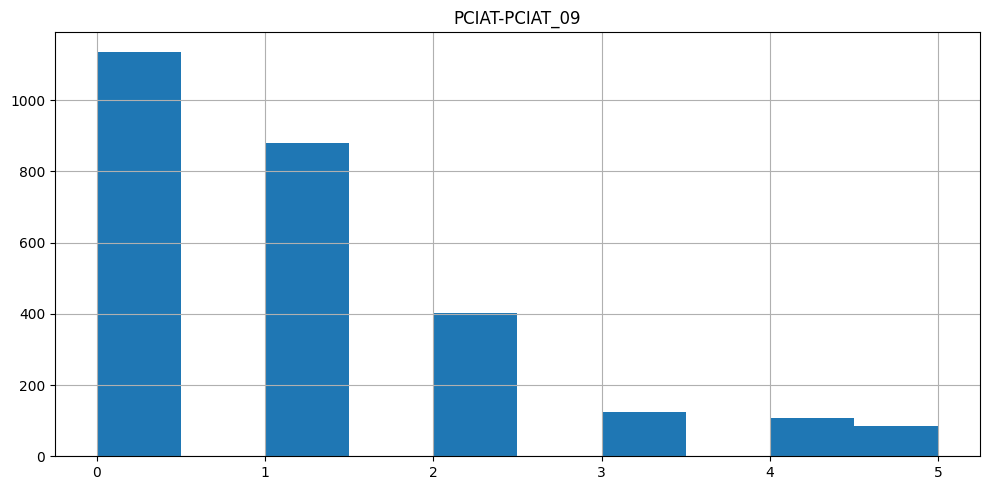

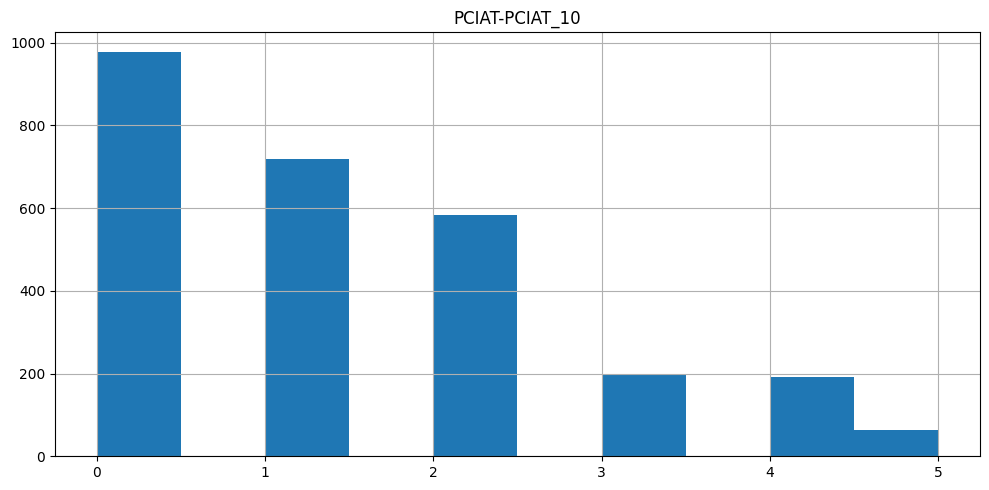

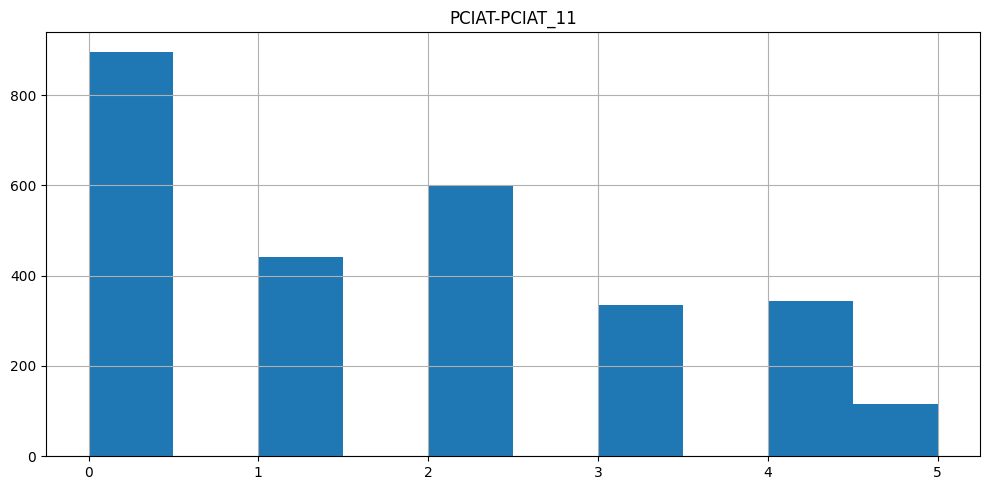

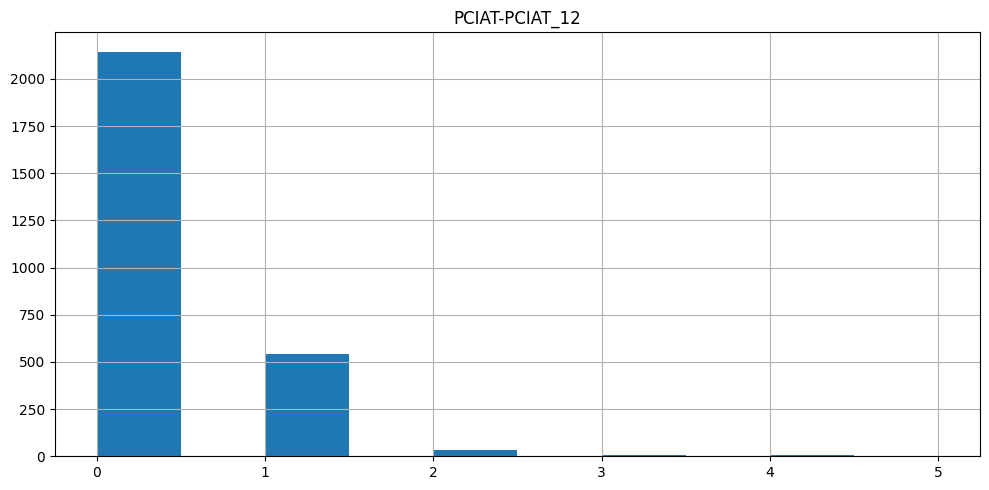

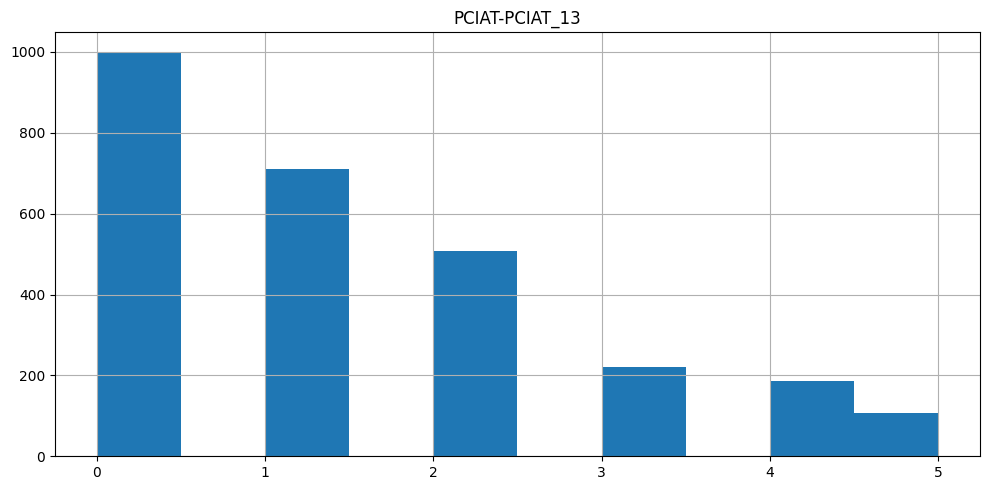

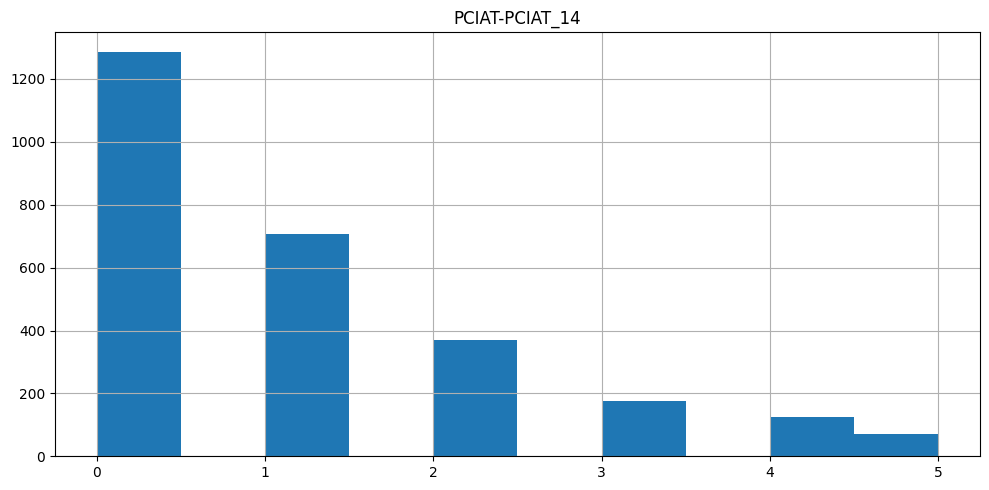

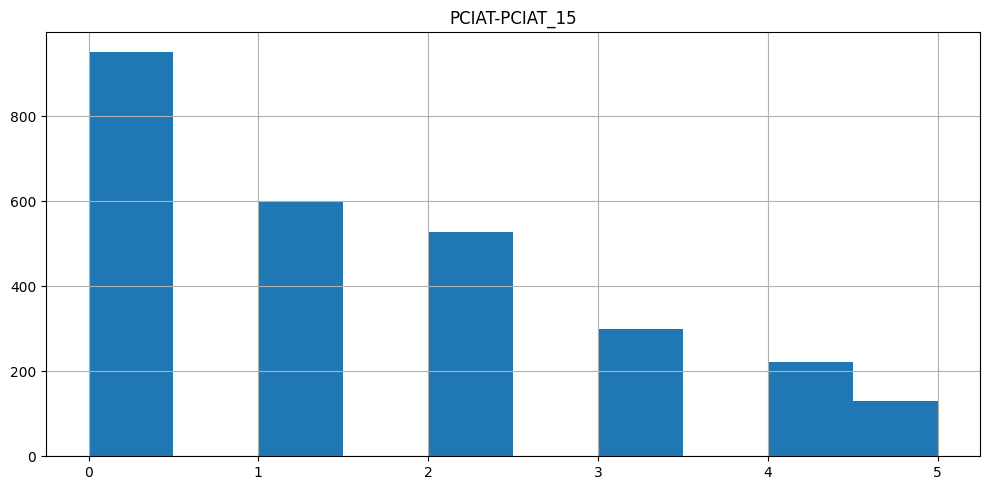

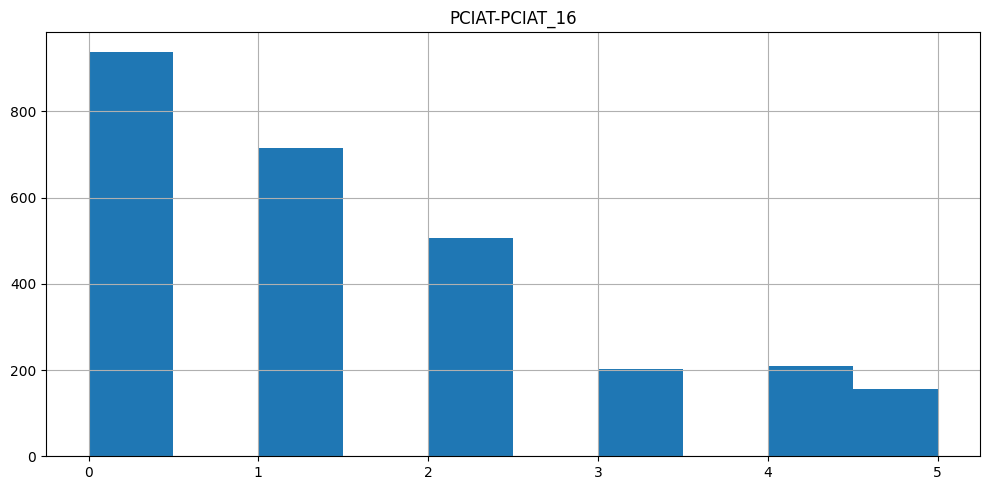

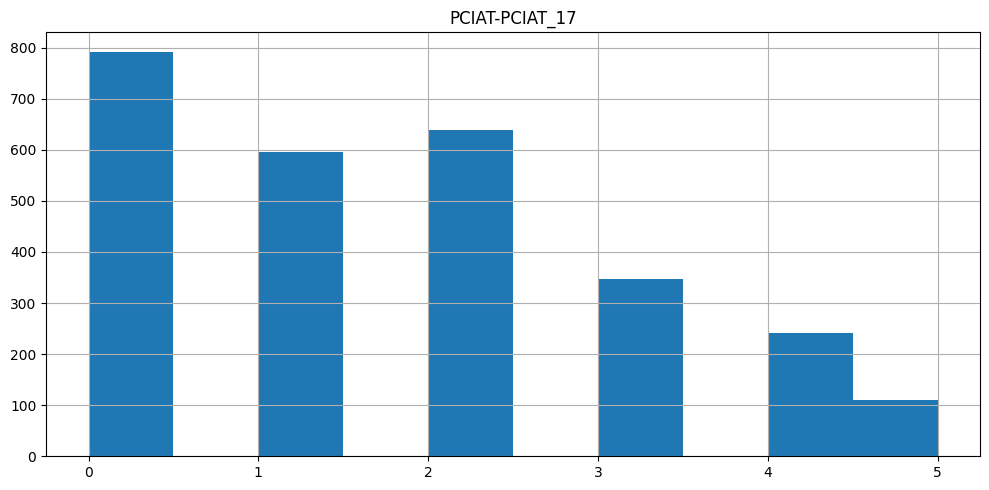

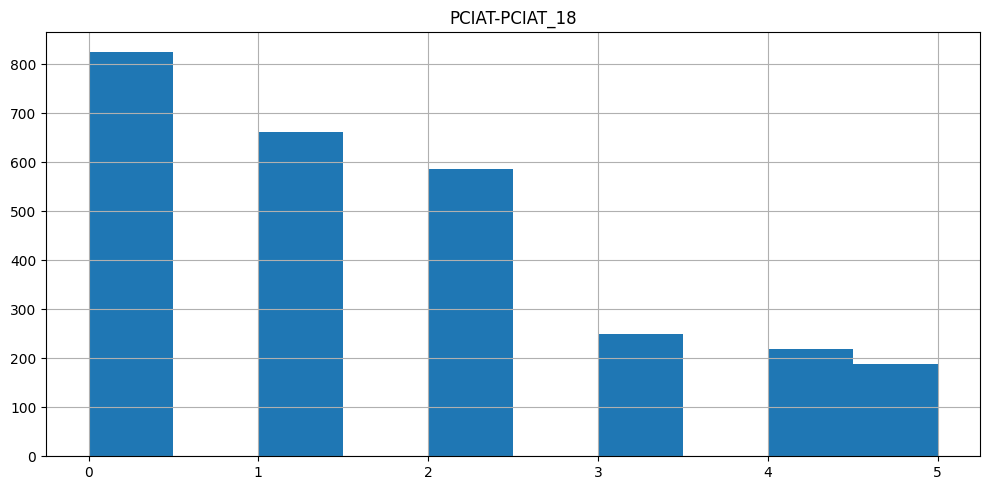

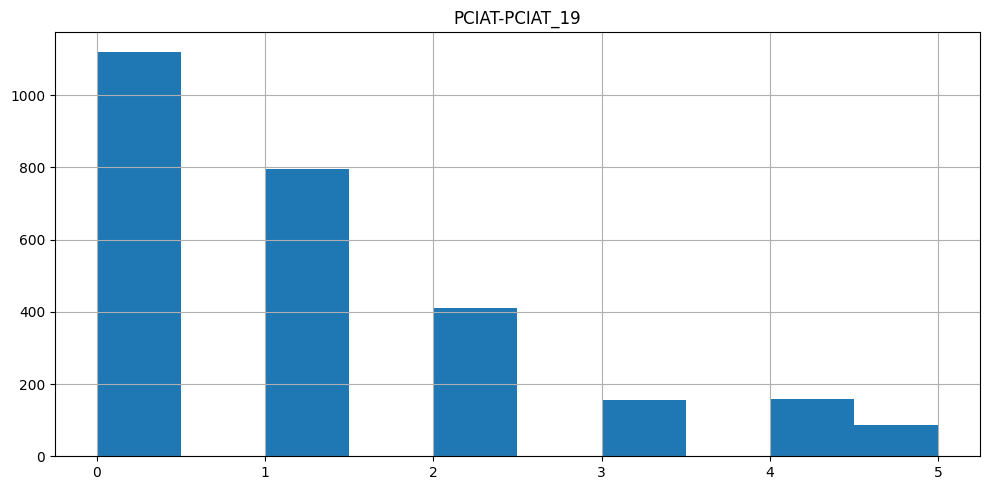

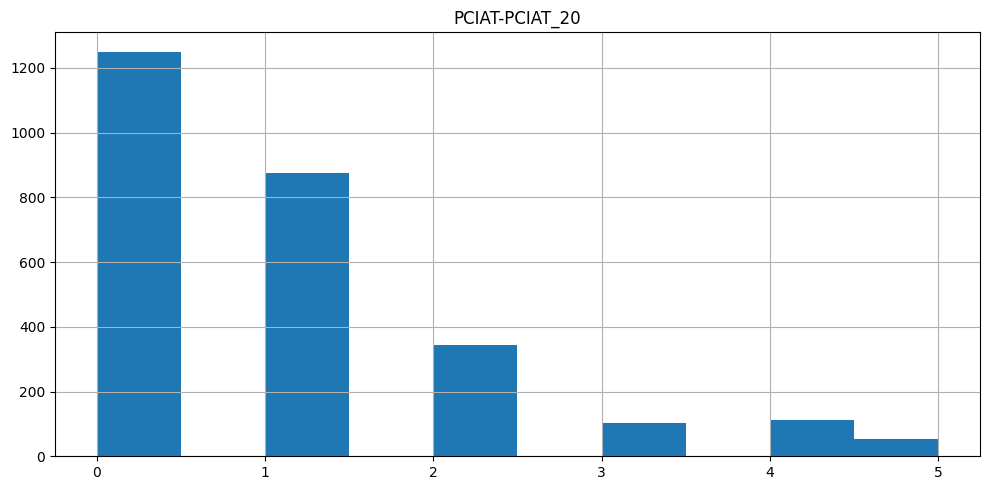

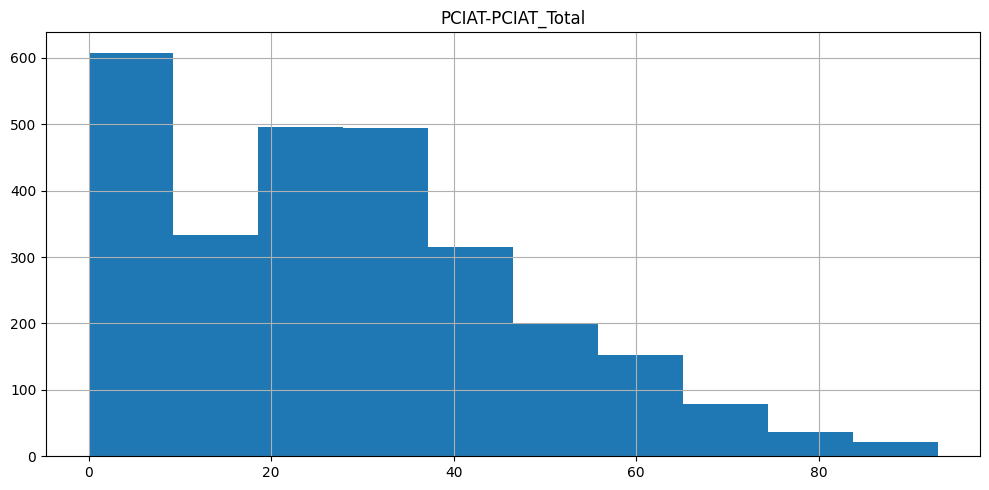

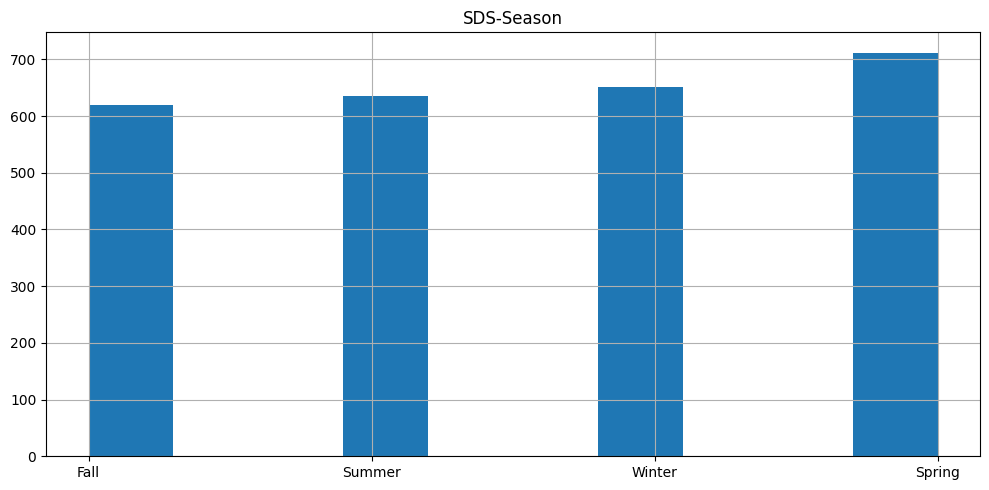

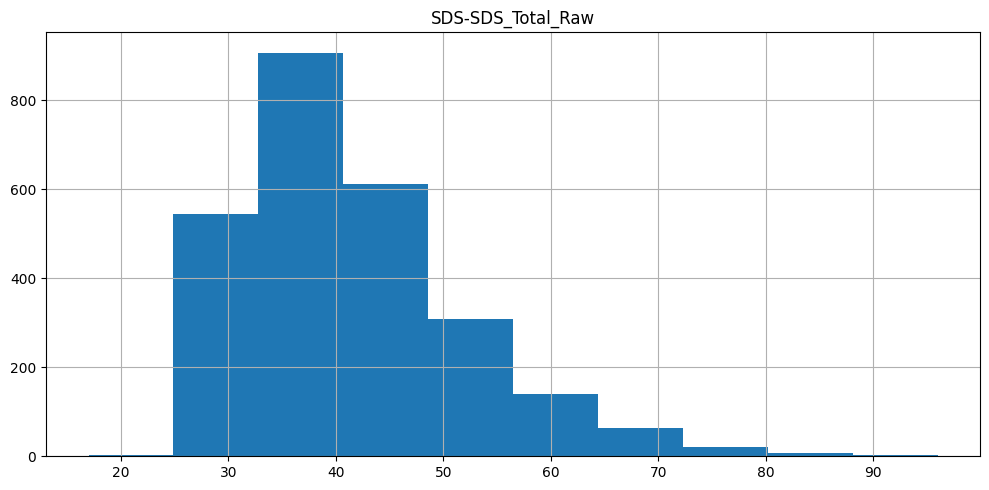

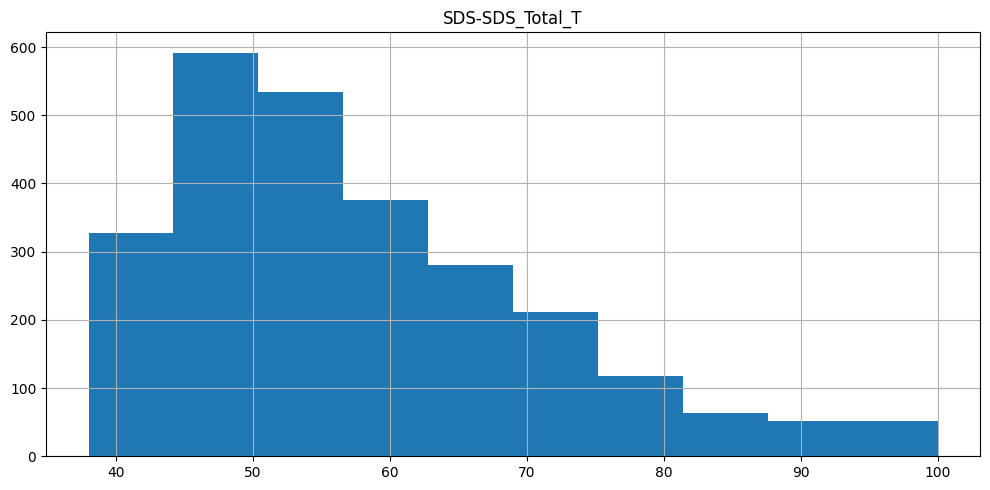

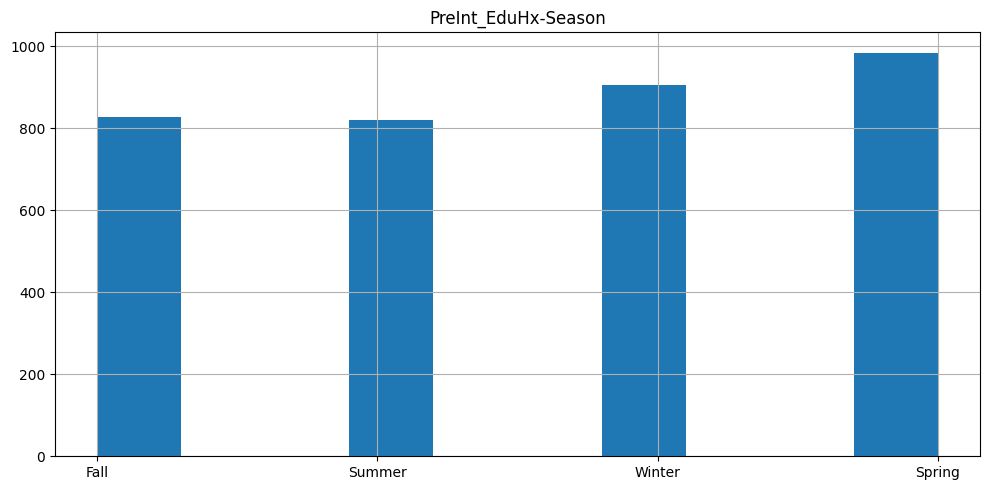

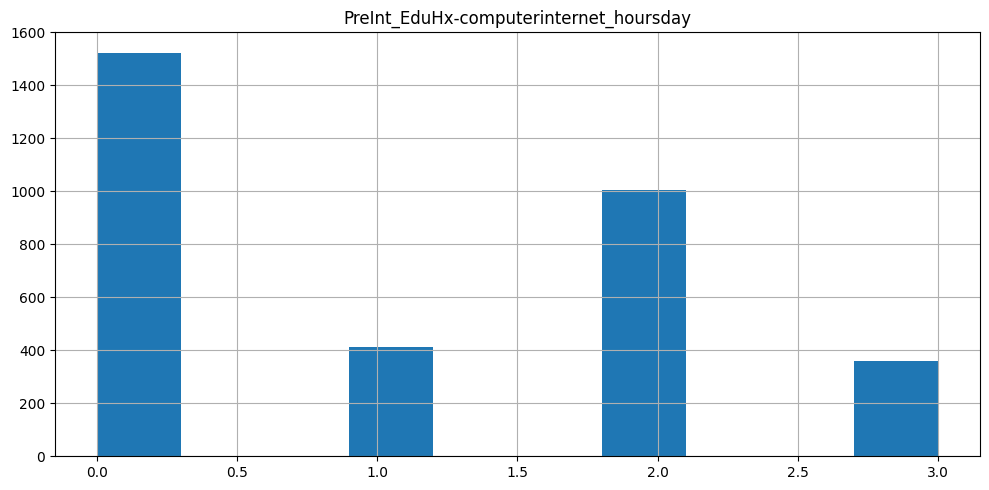

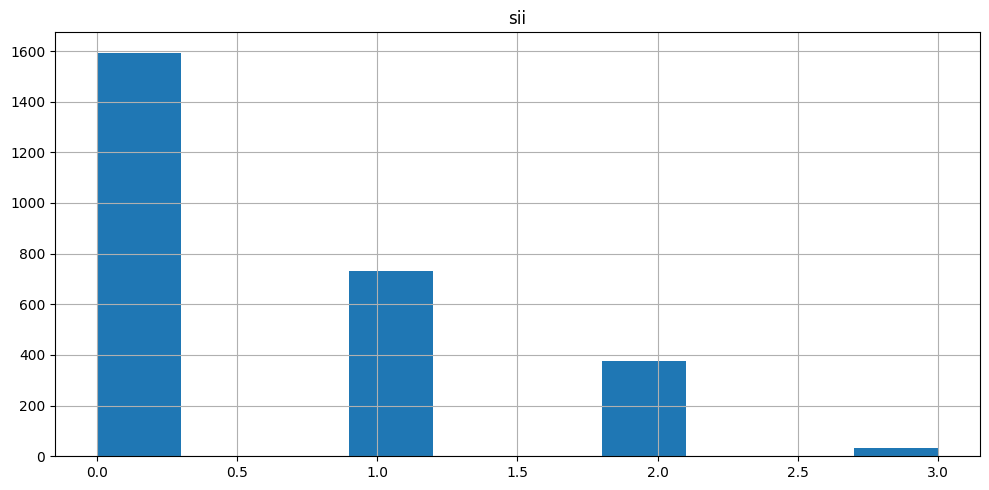

In [73]:
# let's observe the distribution of all numerical values

for feature in train_csv_df.columns:
    train_csv_df[feature].hist(figsize=(10,5))
    plt.title(feature)
    plt.tight_layout()
    plt.show()


In [6]:
# Let's work with one parquet file and observe what it contains
# print(len(file_paths)) # 1002
# p = 0 # 998
# c = 0 # 4???
# for filename in file_paths:
#     if filename.endswith(".parquet"):
#         p+=1
#     elif filename.endswith(".csv"):
#         c+=1
#     else:
#         print(filename)

def process_parquet_files(parquet_file):
    pd.read_parquet()
    











first_df = pd.read_parquet(file_paths[4], engine='auto')
print(first_df.isna().sum())
first_df

998 4
step                   0
X                      0
Y                      0
Z                      0
enmo                   0
anglez                 0
non-wear_flag          0
light                  0
battery_voltage        0
time_of_day            0
weekday                0
quarter                0
relative_date_PCIAT    0
dtype: int64


,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4188.000000,56940000000000,4,3,41.0
1,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4188.500000,56955000000000,4,3,41.0
4,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.000000,57235000000000,4,3,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43325,43325,-0.008333,-0.023620,-1.006901,0.007224,-88.595741,0.0,0.000000,3824.000000,57580000000000,6,3,85.0
43326,43326,0.048730,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.000000,3824.000000,57640000000000,6,3,85.0
43327,43327,0.387370,0.793151,-0.402214,0.069961,-24.097908,0.0,0.000000,3824.000000,57645000000000,6,3,85.0
43328,43328,0.801953,0.501589,-0.040937,0.045489,-2.113776,0.0,0.000000,3824.000000,57650000000000,6,3,85.0


In [3]:
# Now let's start doing some data pre-processing
### 1. get rid of "probably" irrelevant features
first_df.drop(labels=['battery_voltage',"X","Y","Z"], axis=1)
# print(first_df.shape)
# first_df.columns

,step,enmo,anglez,non-wear_flag,light,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.022853,-88.280762,0.0,53.000000,56940000000000,4,3,41.0
1,1,0.020231,-88.241707,0.0,51.666668,56945000000000,4,3,41.0
2,2,0.019893,-88.170067,0.0,50.333332,56950000000000,4,3,41.0
3,3,0.018667,-88.250031,0.0,50.500000,56955000000000,4,3,41.0
4,4,0.016848,-88.130775,0.0,33.166668,57235000000000,4,3,41.0
...,...,...,...,...,...,...,...,...,...
43325,43325,0.007224,-88.595741,0.0,0.000000,57580000000000,6,3,85.0
43326,43326,0.056839,-85.352219,0.0,0.000000,57640000000000,6,3,85.0
43327,43327,0.069961,-24.097908,0.0,0.000000,57645000000000,6,3,85.0
43328,43328,0.045489,-2.113776,0.0,0.000000,57650000000000,6,3,85.0


In [4]:
#help(pd.DataFrame.drop)

In [9]:
#1. Check missing values in all parquet folders:
#2. Normalize the parquet data
#3. Any more cleaning?

# 1 ---> No NaNs in train parquet dataset
df = pd.DataFrame()
i = 4
for file_path in file_paths[4:]:
#     print(df)
#     print(pd.read_parquet(file_path, engine='auto'))
    temp_df = pd.read_parquet(file_path, engine='auto')
    
#     i+= 1
#     print(temp_df.isna().sum().sum())
#     break?
#     if temp_df.isna().sum().sum() > 0:
#         print(i)
#         break

KeyboardInterrupt: 

In [12]:
# 2. Normalize the parquet data
# -> append the dataframes together with df.concat()
# -> 
# -> 
# 3. Clean the parquet data
# 4. Build the model -> what kind of model should I be using??


Python 3.10.14


### Building the model -> logistic regression, ReLU, deep NN

In [14]:
import tensorflow
# Build the model
model = pytorch.Sequence(
    layer1= pytorch.layers(input=SIZE OF DF, output=, 300, activation="relu")
    layer2= pytorch.layers(input=prev output, output = 50,activation="relu")
    # 4 more layers
    final_layer = self.layers(input = prev output, output = 4, activation="sigmoid") # for number of prediction labels 
    output = .index(final_layer.max()) # need a way to transform final layer into a single output
    
)
    
# Loss function    
loss = BCE

# Optimizer (hyperparameters: {"alpha": learning rate, "epochs": number of training loops, "batch size":})


### Training the model

In [ ]:
# no need to split tests because they are already split for us
x_train, y_train, x_test, y_test = pytorch.train_split(dataset)
epochs = 100 # num of training loops

# train set
for epoch in epochs:
    model.train() # train mode
    
    # 1. pass through
    pred_train = model(x_train)
    # 2. calculate the loss
    curr_loss_train = model.loss(y_train, pred_train)
    
    # 3. optimizer zero grad
    optimizer.zero_grad()
    
    # 4 optimize step, step, step
    optimizer.step()
    
    # Record the loss
    loss_train.append(curr_loss_train)
    
# test set (hypothetical)
model.eval()
for ???
# 1. pass through
pred_test = model(x_test)

# 2. 
curr_loss_test = model.loss(y_test, pred_test)

# 3. Record the loss
loss_test.append(curr_loss_test)

In [15]:
!pip install pytorch

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-gdniauq3/pytorch_b9f8862b5f344975a371e2f525c983f5/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects
